# 뉴욕 택시 수요예측

## 필요한 라이브러리를 정리한다. 

In [511]:
# pip3 install dask
# pip3 install folium
# conda install -c conda-forge folium
# conda install -c conda-forge folium
# conda install -c conda-forge xgboost
# pip install gpxpy
# pip3 install scikit-learn
# pip install seaborn

import dask.dataframe as dd ## pandas와 비슷하지만 대용량의 데이터를 처리가능하다. 

import pandas as pd ## 데이터 프레임
import numpy as np ## numpy 활용

import datetime ##unix time으로 변환
import time ##unix time으로 변환


## 맵 사용 라이브러리
import folium

## 시간대 활용
from datetime import timedelta

## 시각화를 위해서
import matplotlib
 
matplotlib.use('nbagg') ## 줌인 줌아웃 할 수 있도록
import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans ## 클러스터링
import gpxpy.geo ## 거리 가져오기

import xgboost as xgb ## xgboost 모델 가져오기

from sklearn.ensemble import RandomForestRegressor ## 랜덤포레스트 모델 가져오기
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")




# 뉴욕 택시 수요를 예측

## 특성시간대에 특정 장소에서의 택시 탑승수를 예측

### * 택시의 수요의 불규등한 분포 / 수요 예측 지점에 따라 택시 공급 조정
### * 신규 가맹택시 사업과 같이 새로운 지역에 택시수요를 확인해볼 때 필요한 내용
### * 뉴욕시 시정부에서 제공하는 뉴욕시 택시 데이터 2015 data -> 2016 data 활용


## 데이터 활용
### 뉴욕택시 데이터 활용 
#### Yellow Taxi: Yellow Medallion Taxicabs/ For Hire Vehicles (FHVs) / Green Taxi: Street Hail Livery (SHL) 데이터 중 Yellow Taxi 데이터 활용 

In [635]:
%ls

NYC Final.ipynb
README.md
Taxi_Demand_Prediction(New york taxi data).ipynb
yellow_tripdata_2015-01.csv
yellow_tripdata_2016-01.csv
yellow_tripdata_2016-02.csv
yellow_tripdata_2016-03.csv


In [5]:
## 데이터 read
df_taxi = pd.read_csv('yellow_tripdata_2015-01.csv')
df_taxi

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  dropoff_latitude  \
0                  1                  N         -73.974785         40.750618   
1                  1                  N         -73.994415         40.759109   
2                  1                  N         -73.951820         40.824413   
3                  1                  N         -74.004326         40.719986   
4                  1                  N         -74.004181         40.742653   
...              ...                ...                ...               ...   
12748981           1                  N         -73.953735         40.775162   
12748982           1                  N         -73.974976         40.720013   
12748983           1                  N         -73.969101         40.787800   
12748984           1                  N         -73.981819         40.737652   
12748985           1                  N         -73.968643         40.760777   

          payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0                    1         12.0    1.0      0.5        3.25           0.0   
1                    1         14.5    0.5      0.5        2.00           0.0   
2                    2          9.5    0.5      0.5        0.00           0.0   
3                    2          3.5    0.5      0.5        0.00           0.0   
4                    2         15.0    0.5      0.5        0.00           0.0   
...                ...          ...    ...      ...         ...           ...   
12748981             1          5.5    0.0      0.5        1.25           0.0   
12748982             1          6.0    0.0      0.5        2.00           0.0   
12748983             2         13.5    0.0      0.5        0.00           0.0   
12748984             1         10.5    0.0      0.5        2.25           0.0   
12748985             2          5.5    0.0      0.5        0.00           0.0   

          improvement_surcharge  total_amount  
0                           0.3         17.05  
1                           0.3         17.80  
2                           0.3         10.80  
3                           0.3          4.80  
4                           0.3         16.30  
...                         ...           ...  
12748981  

In [6]:
## 대용량 데이터 처리하는 라이브러리 활용
df_taxi_d = dd.read_csv('yellow_tripdata_2015-01.csv')

In [636]:
# 데이터의 기본적인 정보확인

## 운임정보 :  https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
## 유저가이드 : https://www1.nyc.gov/assets/tlc/downloads/pdf/trip_record_user_guide.pdf
## 데이터 dictionary : https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf   

# 데이터 전처리

## 뉴욕시 데이터의 범위 정하기

### 1.뉴욕시 좌표를 확인해서 범위에 포함되지 않는 출발점, 도착점 시각화 해보기! 

In [ ]:
## 뉴욕시 위도와 경도확인
### latitude, longitude : (40.5774, -74.15) & (40.9176, - 73.7004)

In [8]:
# 범위를 넘어선 데이터를 확인
## 택시 픽업 장소 중, 뉴욕시 범위를 넘어선 데이터들 나타내기

import folium 

### 뉴욕시 범위 밖 위도와 경도 포인트들
outlier_locations = df_taxi[((df_taxi['pickup_longitude'] <= -74.15) | (df_taxi['pickup_latitude'] <= 40.5774)| \
                   (df_taxi['pickup_longitude'] >= -73.7004) | (df_taxi['pickup_latitude'] >= 40.9176))]

outlier_locations['pickup_longitude'].shape


(247742,)

In [9]:
## 아웃라이어 데이터가 247742개이다. 

In [523]:
# 맵을 생성

map_osm = folium.Map(location = [40.734695, -73.990372], titles='Stanmen Toner')


## 아웃라이어 데이터를 표시해본다. 
## 뉴욕시 범위를 제외한 데이터들을 표시한다.
sample_locations = outlier_locations.head(10000)

for i,j in sample_locations.iterrows(): ## 각각 리턴
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_osm)

map_osm

In [524]:
## 택시가 도착 좌표중 아웃라이어 표시 해보기
### 뉴욕시 범위 밖 위도와 경도 포인트들
outlier_locations = df_taxi[((df_taxi['dropoff_longitude'] <= -74.15) | (df_taxi['dropoff_latitude'] <= 40.5774)| \
                   (df_taxi['dropoff_longitude'] >= -73.7004) | (df_taxi['dropoff_latitude'] >= 40.9176))]

outlier_locations.shape


(264440, 24)

In [525]:
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

## 아웃라이어 데이터를 표시해본다. 
## 뉴욕시 범위를 제외한 다른 곳들을 나타내준다. 
sample_locations = outlier_locations.head(10000)

for i,j in sample_locations.iterrows(): ## 각각 리턴
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(map_osm)

map_osm

## 탑승시간 데이터 확인 & 시각화

In [639]:

from datetime import timedelta

## 타임스탬프가 유닉스로 변환

df_taxi['tpep_dropoff_datetime'] = pd.to_datetime(df_taxi['tpep_dropoff_datetime'], dayfirst = True)
df_taxi['tpep_pickup_datetime'] = pd.to_datetime(df_taxi['tpep_pickup_datetime'], dayfirst = True)

### 이용시간 추출
df_taxi['operation_time'] = df_taxi['tpep_dropoff_datetime'] - (df_taxi['tpep_pickup_datetime'])

In [640]:
df_taxi['operation_time']

0          0 days 00:18:03
1          0 days 00:19:50
2          0 days 00:10:03
3          0 days 00:01:52
4          0 days 00:19:19
                 ...      
12748981   0 days 00:03:56
12748982   0 days 00:05:42
12748983   0 days 00:13:17
12748984   0 days 00:15:19
12748985   0 days 00:05:48
Name: operation_time, Length: 12748986, dtype: timedelta64[ns]

In [641]:
## df['operation_time']에서  0days 제거
# df_taxi['operation_time'] = df_taxi['operation_time'].astype(str)
# df_taxi['operation_time'] = df_taxi['operation_time'].str.replace('0 days',' ')

In [642]:
from datetime import datetime
import time

df_taxi['operation_second'] = df_taxi['operation_time'].dt.total_seconds()
df_taxi

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  ...  mta_tax  \
0                  1                  N         -73.974785  ...      0.5   
1                  1                  N         -73.994415  ...      0.5   
2                  1                  N         -73.951820  ...      0.5   
3                  1                  N         -74.004326  ...      0.5   
4                  1                  N         -74.004181  ...      0.5   
...              ...                ...                ...  ...      ...   
12748981           1                  N         -73.953735  ...      0.5   
12748982           1                  N         -73.974976  ...      0.5   
12748983           1                  N         -73.969101  ...      0.5   
12748984           1                  N         -73.981819  ...      0.5   
12748985           1                  N         -73.968643  ...      0.5   

          tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0               3.25           0.0                    0.3         17.05   
1               2.00           0.0                    0.3         17.80   
2               0.00           0.0                    0.3         10.80   
3               0.00           0.0                    0.3          4.80   
4               0.00           0.0                    0.3         16.30   
...              ...           ...                    ...           ...   
12748981        1.25           0.0                    0.3          7.55   
12748982        2.00           0.0                    0.3          8.80   
12748983        0.00           0.0                    0.3         14.30   
12748984        2.25           0.0                    0.3         13.55   
12748985        0.00           0.0                    0.3          6.30   

          operation_time  operation_second  operation_min      speed  \
0        0 days 00:18:03            1083.0      18.050000   5.285319   
1        0 days 00:19:50            1190.0      19.833333   9.983193   
2        0 days 00:10:03             603.0      10.050000  10.746269   
3        0 days 00:01:52             112.0       1.866667  16.071429   
4        0 days 00:19:19            1159.0      19.316667   9.318378   
...                  ...          

In [643]:
## 여기서 직관적으로 이해할 수 있도록, 운행시간을 초단위가 아닌 분단위로 정리한다.
df_taxi['operation_min'] = df_taxi['operation_second']/60
df_taxi

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  ...  mta_tax  \
0                  1                  N         -73.974785  ...      0.5   
1                  1                  N         -73.994415  ...      0.5   
2                  1                  N         -73.951820  ...      0.5   
3                  1                  N         -74.004326  ...      0.5   
4                  1                  N         -74.004181  ...      0.5   
...              ...                ...                ...  ...      ...   
12748981           1                  N         -73.953735  ...      0.5   
12748982           1                  N         -73.974976  ...      0.5   
12748983           1                  N         -73.969101  ...      0.5   
12748984           1                  N         -73.981819  ...      0.5   
12748985           1                  N         -73.968643  ...      0.5   

          tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0               3.25           0.0                    0.3         17.05   
1               2.00           0.0                    0.3         17.80   
2               0.00           0.0                    0.3         10.80   
3               0.00           0.0                    0.3          4.80   
4               0.00           0.0                    0.3         16.30   
...              ...           ...                    ...           ...   
12748981        1.25           0.0                    0.3          7.55   
12748982        2.00           0.0                    0.3          8.80   
12748983        0.00           0.0                    0.3         14.30   
12748984        2.25           0.0                    0.3         13.55   
12748985        0.00           0.0                    0.3          6.30   

          operation_time  operation_second  operation_min      speed  \
0        0 days 00:18:03            1083.0      18.050000   5.285319   
1        0 days 00:19:50            1190.0      19.833333   9.983193   
2        0 days 00:10:03             603.0      10.050000  10.746269   
3        0 days 00:01:52             112.0       1.866667  16.071429   
4        0 days 00:19:19            1159.0      19.316667   9.318378   
...                  ...          

In [644]:
## 택시speed도 정리
df_taxi['speed'] = (df_taxi['trip_distance']/df_taxi['operation_min'])*60
df_taxi

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  ...  mta_tax  \
0                  1                  N         -73.974785  ...      0.5   
1                  1                  N         -73.994415  ...      0.5   
2                  1                  N         -73.951820  ...      0.5   
3                  1                  N         -74.004326  ...      0.5   
4                  1                  N         -74.004181  ...      0.5   
...              ...                ...                ...  ...      ...   
12748981           1                  N         -73.953735  ...      0.5   
12748982           1                  N         -73.974976  ...      0.5   
12748983           1                  N         -73.969101  ...      0.5   
12748984           1                  N         -73.981819  ...      0.5   
12748985           1                  N         -73.968643  ...      0.5   

          tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0               3.25           0.0                    0.3         17.05   
1               2.00           0.0                    0.3         17.80   
2               0.00           0.0                    0.3         10.80   
3               0.00           0.0                    0.3          4.80   
4               0.00           0.0                    0.3         16.30   
...              ...           ...                    ...           ...   
12748981        1.25           0.0                    0.3          7.55   
12748982        2.00           0.0                    0.3          8.80   
12748983        0.00           0.0                    0.3         14.30   
12748984        2.25           0.0                    0.3         13.55   
12748985        0.00           0.0                    0.3          6.30   

          operation_time  operation_second  operation_min      speed  \
0        0 days 00:18:03            1083.0      18.050000   5.285319   
1        0 days 00:19:50            1190.0      19.833333   9.983193   
2        0 days 00:10:03             603.0      10.050000  10.746269   
3        0 days 00:01:52             112.0       1.866667  16.071429   
4        0 days 00:19:19            1159.0      19.316667   9.318378   
...                  ...          

In [22]:
## pickup_times정리
import time
import datetime
from dask.base import compute


## 타임스탬프를 unix 타임으로 바꿔준다.
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

duration =df_taxi_d[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()



In [23]:
duration

tpep_pickup_datetime tpep_dropoff_datetime
0      2015-01-15 19:05:39   2015-01-15 19:23:42
1      2015-01-10 20:33:38   2015-01-10 20:53:28
2      2015-01-10 20:33:38   2015-01-10 20:43:41
3      2015-01-10 20:33:39   2015-01-10 20:35:31
4      2015-01-10 20:33:39   2015-01-10 20:52:58
...                    ...                   ...
12615  2015-01-10 19:01:44   2015-01-10 19:05:40
12616  2015-01-10 19:01:44   2015-01-10 19:07:26
12617  2015-01-10 19:01:44   2015-01-10 19:15:01
12618  2015-01-10 19:01:44   2015-01-10 19:17:03
12619  2015-01-10 19:01:45   2015-01-10 19:07:33

[12748986 rows x 2 columns]

In [24]:
## 픽업 타임즈 값 뽑아내기 
duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]

In [25]:
duration_pickup

[1421316339.0,
 1420889618.0,
 1420889618.0,
 1420889619.0,
 1420889619.0,
 1420889619.0,
 1420889619.0,
 1420889619.0,
 1420889619.0,
 1420889620.0,
 1420889620.0,
 1420889621.0,
 1420889621.0,
 1420889621.0,
 1420889621.0,
 1421316339.0,
 1421316340.0,
 1421316340.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316341.0,
 1421316342.0,
 1421316342.0,
 1421316342.0,
 1421316342.0,
 1421316342.0,
 1421316343.0,
 1421316343.0,
 1421316343.0,
 1421316343.0,
 1421316344.0,
 1420884741.0,
 1420884741.0,
 1422112384.0,
 1422112385.0,
 1422112385.0,
 1422112385.0,
 1422112386.0,
 1422112386.0,
 1422112386.0,
 1422112386.0,
 1422112386.0,
 1422112386.0,
 1422112387.0,
 1422112387.0,
 1422112387.0,
 1422112387.0,
 1422112388.0,
 1422112388.0,
 1422112389.0,
 1422112389.0,
 1422112389.0,
 1422112389.0,
 1422112389.0,
 1420346691.0,
 1420346691.0,
 1420346692.0,
 1420346692.0,
 1420346692.0,
 1420346692.0,
 1420346692.0,
 142034669

In [26]:
df_taxi['pickup_times'] = duration_pickup

In [27]:
df_taxi

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  ...  mta_tax  \
0                  1                  N         -73.974785  ...      0.5   
1                  1                  N         -73.994415  ...      0.5   
2                  1                  N         -73.951820  ...      0.5   
3                  1                  N         -74.004326  ...      0.5   
4                  1                  N         -74.004181  ...      0.5   
...              ...                ...                ...  ...      ...   
12748981           1                  N         -73.953735  ...      0.5   
12748982           1                  N         -73.974976  ...      0.5   
12748983           1                  N         -73.969101  ...      0.5   
12748984           1                  N         -73.981819  ...      0.5   
12748985           1                  N         -73.968643  ...      0.5   

          tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0               3.25           0.0                    0.3         17.05   
1               2.00           0.0                    0.3         17.80   
2               0.00           0.0                    0.3         10.80   
3               0.00           0.0                    0.3          4.80   
4               0.00           0.0                    0.3         16.30   
...              ...           ...                    ...           ...   
12748981        1.25           0.0                    0.3          7.55   
12748982        2.00           0.0                    0.3          8.80   
12748983        0.00           0.0                    0.3         14.30   
12748984        2.25           0.0                    0.3         13.55   
12748985        0.00           0.0                    0.3          6.30   

          operation_time  operation_second  operation_min      speed  \
0        0 days 00:18:03            1083.0      18.050000   5.285319   
1        0 days 00:19:50            1190.0      19.833333   9.983193   
2        0 days 00:10:03             603.0      10.050000  10.746269   
3        0 days 00:01:52             112.0       1.866667  16.071429   
4        0 days 00:19:19            1159.0      19.316667   9.318378   
...                  ...          

<IPython.core.display.Javascript object>


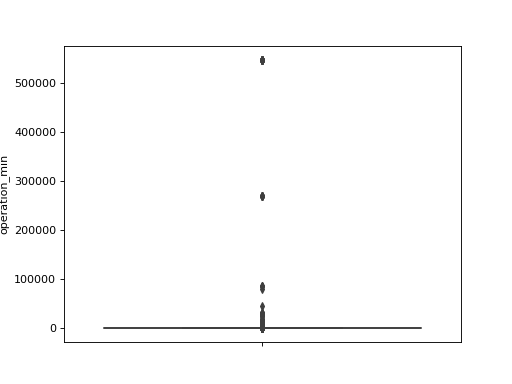

In [526]:
## 시각화

import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots

sns.boxplot(y='operation_min', data = df_taxi)
plt.show()

In [29]:
## 아웃라이어 프린트 해보기
import numpy as np

for i in range(0,100,10):
    var =df_taxi['operation_min'].values # df_taxi['operation_min'] 각 값을 var 변수에 넣어준다.
    var =np.sort(var,axis = None) #값을 np.sort 정렬해준다.
    
    print("{} % 값은 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 % 값은", var[-1])
   

0 % 값은 -1211.0166666666667
10 % 값은 3.833333333333334
20 % 값은 5.383333333333334
30 % 값은 6.816666666666666
40 % 값은 8.3
50 % 값은 9.95
60 % 값은 11.866666666666667
70 % 값은 14.283333333333333
80 % 값은 17.633333333333333
90 % 값은 23.45
100 % 값은 548555.6333333334


In [30]:
for i in range(90,100):
    var = df_taxi['operation_min'].values
    var = np.sort(var, axis=None)
    
    print("{} %은 {}".format(i, var[int(len(var)*(float(i)/100))]))
          
print("100 % 값은", var[-1])
   

90 %은 23.45
91 %은 24.35
92 %은 25.383333333333333
93 %은 26.55
94 %은 27.933333333333334
95 %은 29.583333333333332
96 %은 31.683333333333337
97 %은 34.46666666666667
98 %은 38.71666666666667
99 %은 46.75
100 % 값은 548555.6333333334


In [31]:
## 0%에서 운영시간은 음수값이 나올 수 없으므로, 처리한다. 
## 100% 24시간을 720분로 생각해보면, 548555/60*24 = 약38일이 나오기 때문에 아웃라이어로 처리한다. 
## 그래서 최소값 1분에서 최대값 720분으로 정리한다.

In [32]:
## 논리적으로 이해 가지 않는 범위의 아웃라이어 정리
df_taxi_operation_time_modified=df_taxi[(df_taxi['operation_min']>1) & (df_taxi['operation_min']<720)]
df_taxi_operation_time_modified.shape

(12636784, 24)

<IPython.core.display.Javascript object>


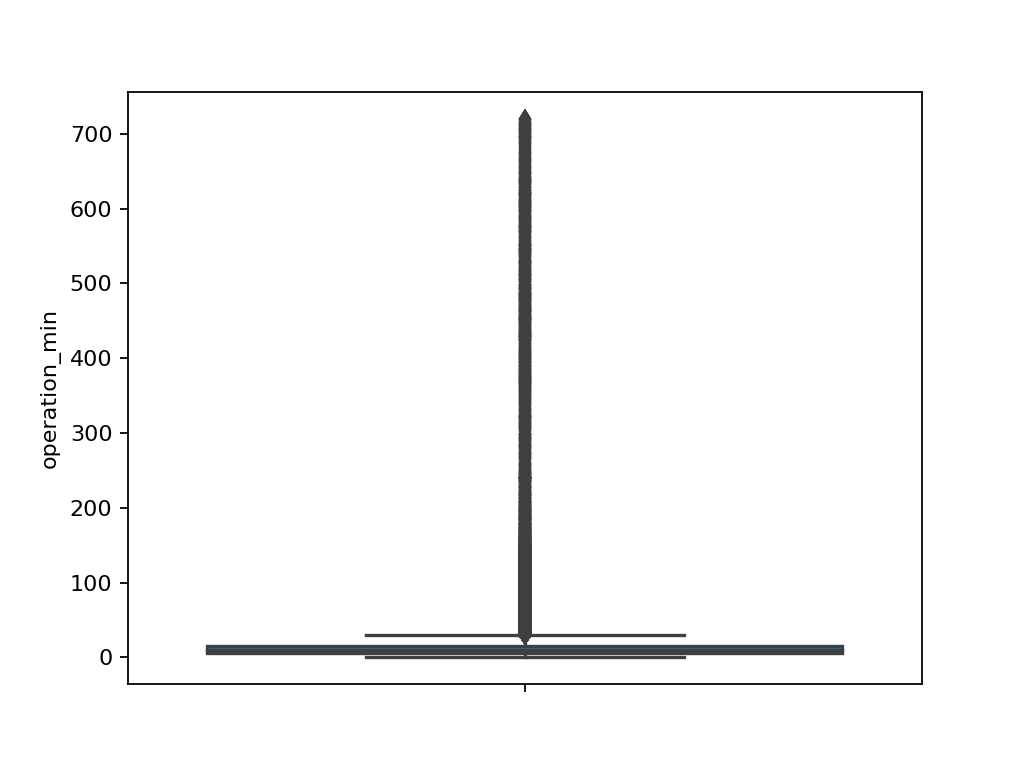

In [33]:
## 시각 화
sns.boxplot(y='operation_min', data = df_taxi_operation_time_modified)
plt.show()

## 택시 스피드 아웃라이어 제거

In [35]:
## 택시 운행시간 제거 후 택시 스피드 확인
df_taxi_operation_time_modified['speed'] = (df_taxi['trip_distance']/df_taxi['operation_min'])*60
df_taxi_operation_time_modified                                                                                                         

<ipython-input-35-4759ef4d379a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxi_operation_time_modified['speed'] = (df_taxi['trip_distance']/df_taxi['operation_min'])*60


VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                2  2015-01-15 19:05:39   2015-01-15 19:23:42   
1                1  2015-01-10 20:33:38   2015-01-10 20:53:28   
2                1  2015-01-10 20:33:38   2015-01-10 20:43:41   
3                1  2015-01-10 20:33:39   2015-01-10 20:35:31   
4                1  2015-01-10 20:33:39   2015-01-10 20:52:58   
...            ...                  ...                   ...   
12748981         1  2015-01-10 19:01:44   2015-01-10 19:05:40   
12748982         1  2015-01-10 19:01:44   2015-01-10 19:07:26   
12748983         1  2015-01-10 19:01:44   2015-01-10 19:15:01   
12748984         1  2015-01-10 19:01:44   2015-01-10 19:17:03   
12748985         1  2015-01-10 19:01:45   2015-01-10 19:07:33   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                       1           1.59        -73.993896        40.750111   
1                       1           3.30        -74.001648        40.724243   
2                       1           1.80        -73.963341        40.802788   
3                       1           0.50        -74.009087        40.713818   
4                       1           3.00        -73.971176        40.762428   
...                   ...            ...               ...              ...   
12748981                2           1.00        -73.951988        40.786217   
12748982                2           0.80        -73.982742        40.728184   
12748983                1           3.40        -73.979324        40.749550   
12748984                1           1.30        -73.999565        40.738483   
12748985                1           0.70        -73.960350        40.766399   

          RateCodeID store_and_fwd_flag  dropoff_longitude  ...  mta_tax  \
0                  1                  N         -73.974785  ...      0.5   
1                  1                  N         -73.994415  ...      0.5   
2                  1                  N         -73.951820  ...      0.5   
3                  1                  N         -74.004326  ...      0.5   
4                  1                  N         -74.004181  ...      0.5   
...              ...                ...                ...  ...      ...   
12748981           1                  N         -73.953735  ...      0.5   
12748982           1                  N         -73.974976  ...      0.5   
12748983           1                  N         -73.969101  ...      0.5   
12748984           1                  N         -73.981819  ...      0.5   
12748985           1                  N         -73.968643  ...      0.5   

          tip_amount  tolls_amount  improvement_surcharge  total_amount  \
0               3.25           0.0                    0.3         17.05   
1               2.00           0.0                    0.3         17.80   
2               0.00           0.0                    0.3         10.80   
3               0.00           0.0                    0.3          4.80   
4               0.00           0.0                    0.3         16.30   
...              ...           ...                    ...           ...   
12748981        1.25           0.0                    0.3          7.55   
12748982        2.00           0.0                    0.3          8.80   
12748983        0.00           0.0                    0.3         14.30   
12748984        2.25           0.0                    0.3         13.55   
12748985        0.00           0.0                    0.3          6.30   

          operation_time  operation_second  operation_min      speed  \
0        0 days 00:18:03            1083.0      18.050000   5.285319   
1        0 days 00:19:50            1190.0      19.833333   9.983193   
2        0 days 00:10:03             603.0      10.050000  10.746269   
3        0 days 00:01:52             112.0       1.866667  16.071429   
4        0 days 00:19:19            1159.0      19.316667   9.318378   
...                  ...          

<IPython.core.display.Javascript object>


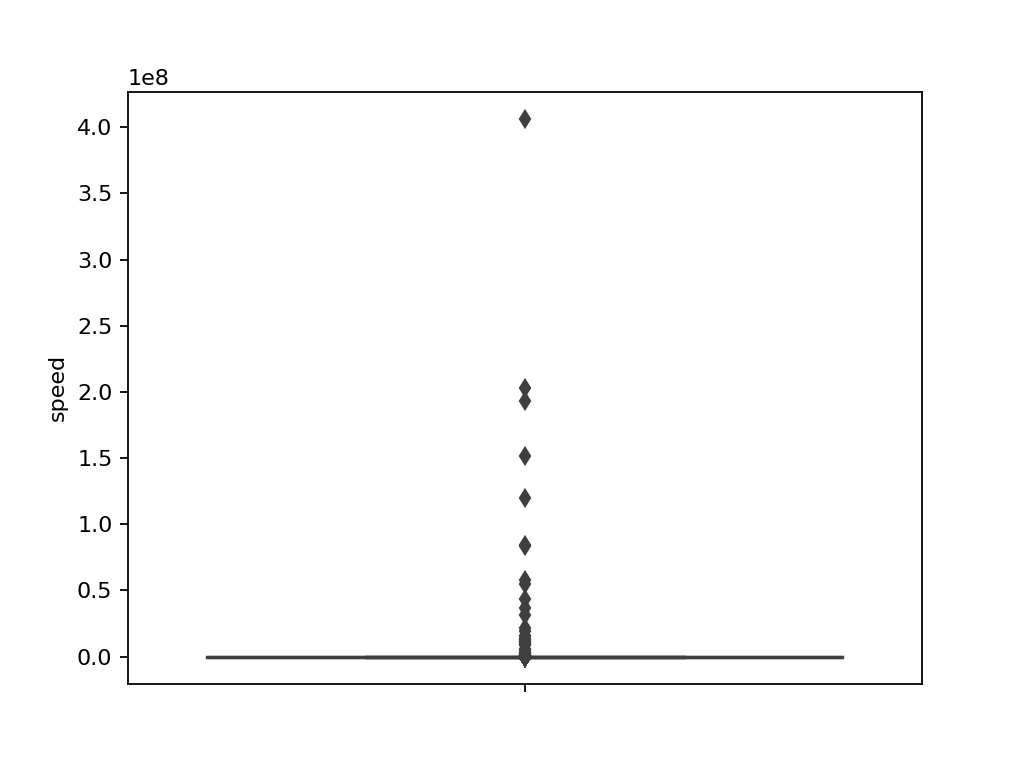

In [36]:
sns.boxplot(y="speed", data =df_taxi)
plt.show()

In [37]:
## 스피드 퍼센테이지별로 10%씩 확인
for i in range(0,100,10):
    var = df_taxi_operation_time_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100 %는 ", var[-1])

0 %는 0.0
10 %는 6.409495548961425
20 %는 7.80918091809181
30 %는 8.929133858267717
40 %는 9.98019801980198
50 %는 11.068814055636896
60 %는 12.286689419795222
70 %는 13.796791443850267
80 %는 15.964285714285714
90 %는 20.188235294117643
100 %는  192857142.85714284


In [38]:
## 1%씩 디테일하게 체크
for i in range(90,100):
    var = df_taxi_operation_time_modified['speed'].values
    var = np.sort(var, axis=None)
    
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100%는", var[-1])

90 %는 20.188235294117643
91 %는 20.91743119266055
92 %는 21.754385964912284
93 %는 22.72340425531915
94 %는 23.84565916398714
95 %는 25.183486238532108
96 %는 26.80851063829787
97 %는 28.843813387423936
98 %는 31.59183673469387
99 %는 35.75286041189931
100%는 192857142.85714284


In [39]:
## 0.1% 더 디테일하게 체크
for i in np.arange(0.0,1.0,0.1): # 90%에서 디테일하게 보기
    var = df_taxi_operation_time_modified['speed'].values
    var = np.sort(var, axis=None)
    
    print("{} %는 {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100%는", var[-1])

99.0 %는 35.75286041189931
99.1 %는 36.312364425162684
99.2 %는 36.91672401927048
99.3 %는 37.59036144578313
99.4 %는 38.332225913621265
99.5 %는 39.17826825127335
99.6 %는 40.15655577299413
99.7 %는 41.342756183745585
99.8 %는 42.87162162162162
99.9 %는 45.31858407079647
100%는 192857142.85714284


In [40]:
## 아웃라이어를 제거하고 범위를 설정한다.
df_taxi_operation_time_modified = df_taxi[(df_taxi['speed']>0) & (df_taxi['speed']<45.31)]


<IPython.core.display.Javascript object>


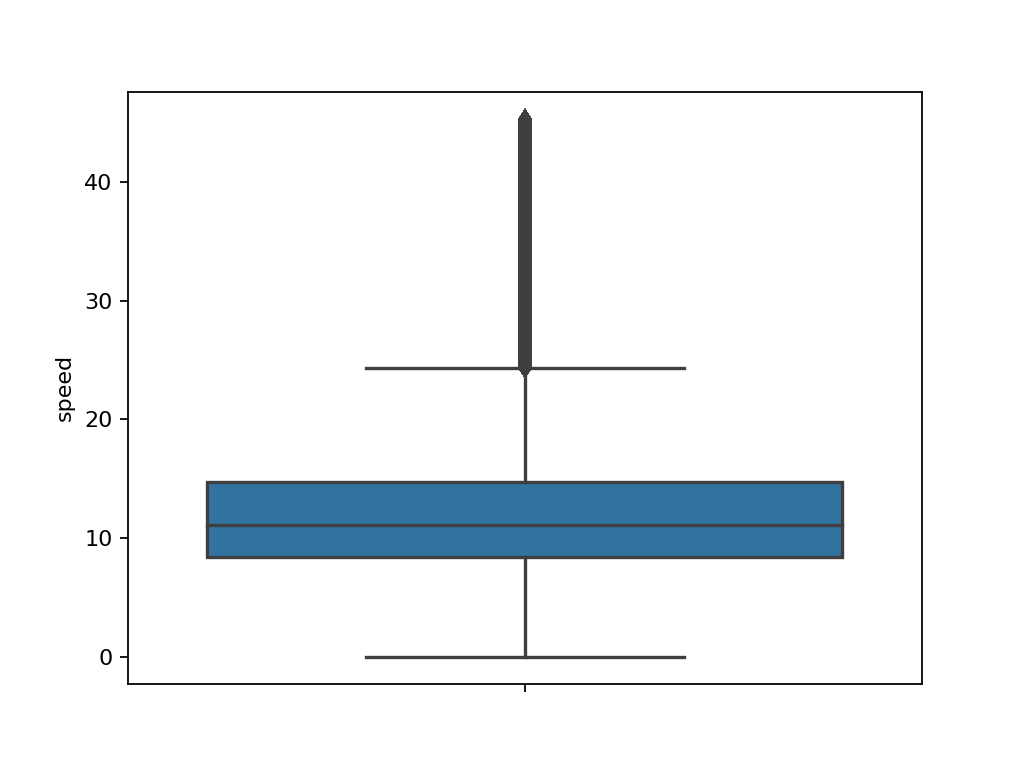

In [41]:
sns.boxplot(y="speed", data =df_taxi_operation_time_modified)
plt.show()

In [42]:
## 뉴욕 옐로우 택시 평균 속도
sum(df_taxi_operation_time_modified['speed'])/float(len(df_taxi_operation_time_modified['speed']))

12.450173996027528

In [43]:
## 평균속도는 12.45 miles/hr, 2miles 당 10분 걸림

### 운행거리

<IPython.core.display.Javascript object>


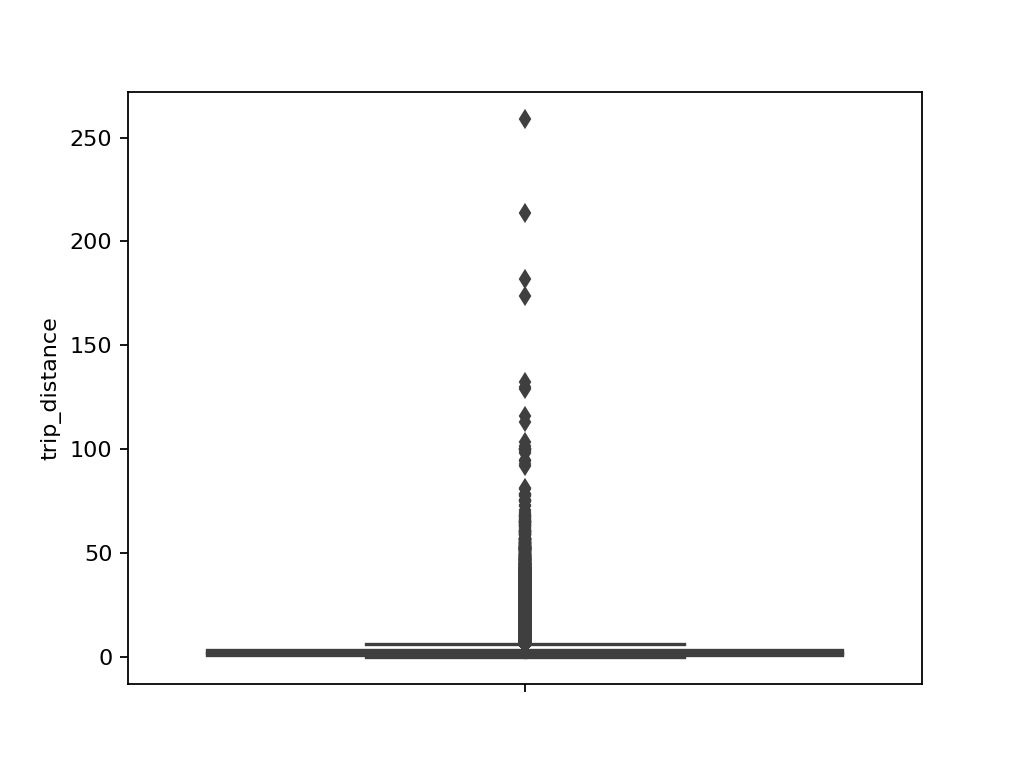

In [44]:
sns.boxplot(y="trip_distance", data = df_taxi_operation_time_modified)
plt.show()

In [45]:
## 10%씩 체크
for i in range(0,100,10):
    var = df_taxi_operation_time_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100%는",var[-1])

0 %는 0.01
10 %는 0.66
20 %는 0.9
30 %는 1.1
40 %는 1.39
50 %는 1.69
60 %는 2.07
70 %는 2.6
80 %는 3.6
90 %는 5.97
100%는 258.9


In [46]:
## 1%씩 체크
for i in range(90,100):
    var = df_taxi_operation_time_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100%는",var[-1])

90 %는 5.97
91 %는 6.45
92 %는 7.07
93 %는 7.85
94 %는 8.72
95 %는 9.6
96 %는 10.6
97 %는 12.1
98 %는 16.03
99 %는 18.17
100%는 258.9


In [47]:
## 0.1%씩 체크
for i in np.arange(0.0,1.0,0.1):
    var = df_taxi_operation_time_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100%는",var[-1])

99.0 %는 18.17
99.1 %는 18.37
99.2 %는 18.6
99.3 %는 18.83
99.4 %는 19.13
99.5 %는 19.5
99.6 %는 19.96
99.7 %는 20.5
99.8 %는 21.22
99.9 %는 22.57
100%는 258.9


In [48]:
## 범위를 설정하고 아웃아리어를 제거하고 한 범위 설정
df_taxi_operation_time_modified = df_taxi[(df_taxi['trip_distance']>0) & (df_taxi['trip_distance']<23)]



<IPython.core.display.Javascript object>


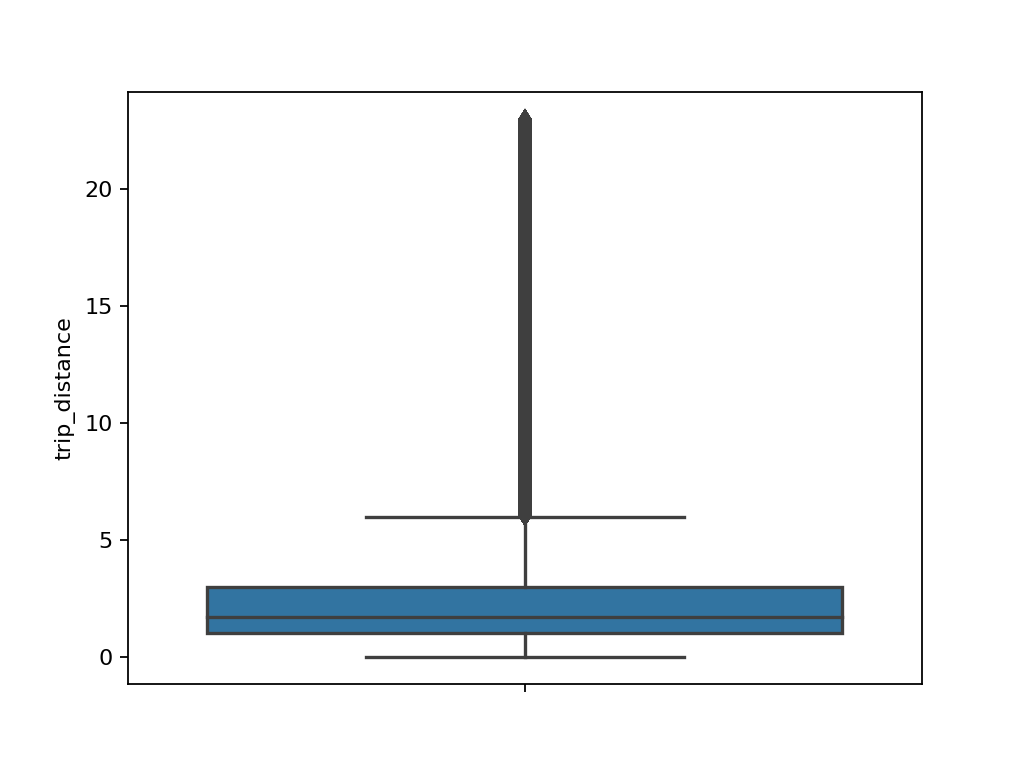

In [49]:
sns.boxplot(y='trip_distance', data= df_taxi_operation_time_modified)
plt.show()

In [50]:
## 아웃라이어 제거 

### 택시 요금

<IPython.core.display.Javascript object>


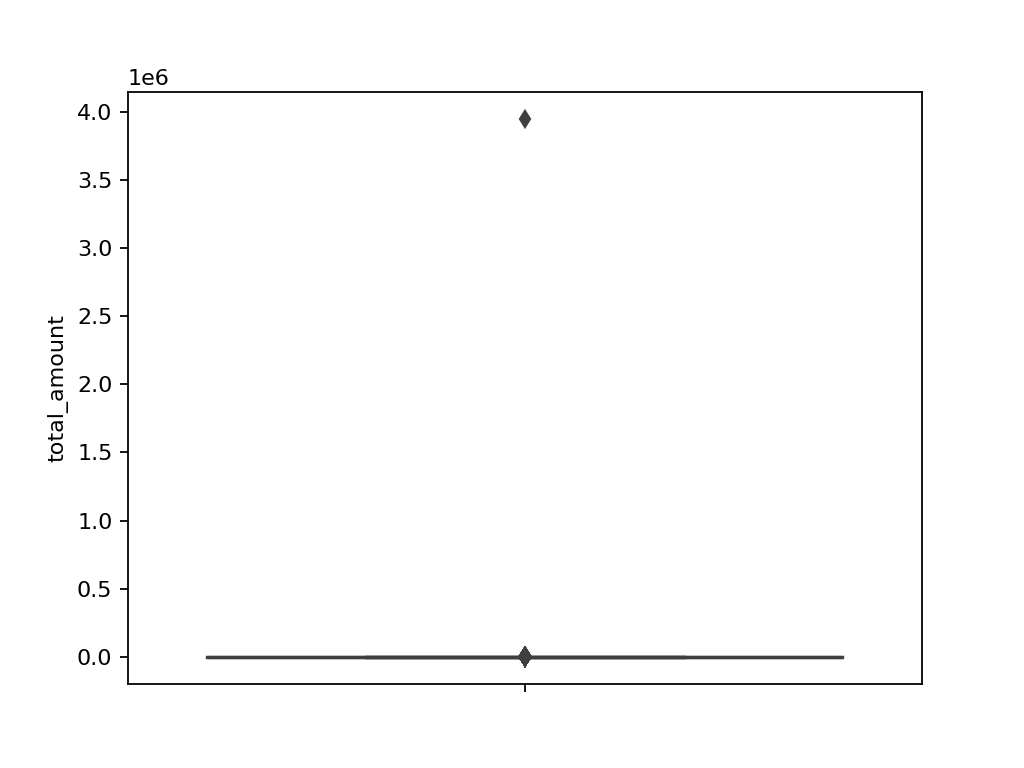

In [51]:
sns.boxplot(y='total_amount', data=df_taxi_operation_time_modified)
plt.show()

In [52]:
## 10%씩 체크
for i in range(0,100,10):
    var = df_taxi_operation_time_modified['total_amount'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100%는",var[-1])

0 %는 -242.55
10 %는 6.3
20 %는 7.8
30 %는 8.8
40 %는 9.8
50 %는 11.16
60 %는 12.8
70 %는 14.8
80 %는 18.3
90 %는 25.8
100%는 3950611.6


In [53]:
## 1%씩 체크
for i in range(90,100):
    var = df_taxi_operation_time_modified['total_amount'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(i, var[int(len(var)*(float(i)/100))]))
print("100%는",var[-1])

90 %는 25.8
91 %는 27.3
92 %는 29.3
93 %는 31.8
94 %는 34.8
95 %는 38.53
96 %는 42.6
97 %는 48.13
98 %는 58.13
99 %는 66.13
100%는 3950611.6


In [54]:
## 0.1%씩 체크
for i in np.arange(0.0,1.0,0.1):
    var = df_taxi_operation_time_modified['total_amount'].values
    var = np.sort(var, axis=None)
    print("{} %는 {}".format(99+i, var[int(len(var)*(float(99+i)/100))]))
print("100%는",var[-1])

99.0 %는 66.13
99.1 %는 68.13
99.2 %는 69.6
99.3 %는 69.6
99.4 %는 69.73
99.5 %는 69.75
99.6 %는 69.76
99.7 %는 72.58
99.8 %는 75.35
99.9 %는 88.28
100%는 3950611.6


<IPython.core.display.Javascript object>


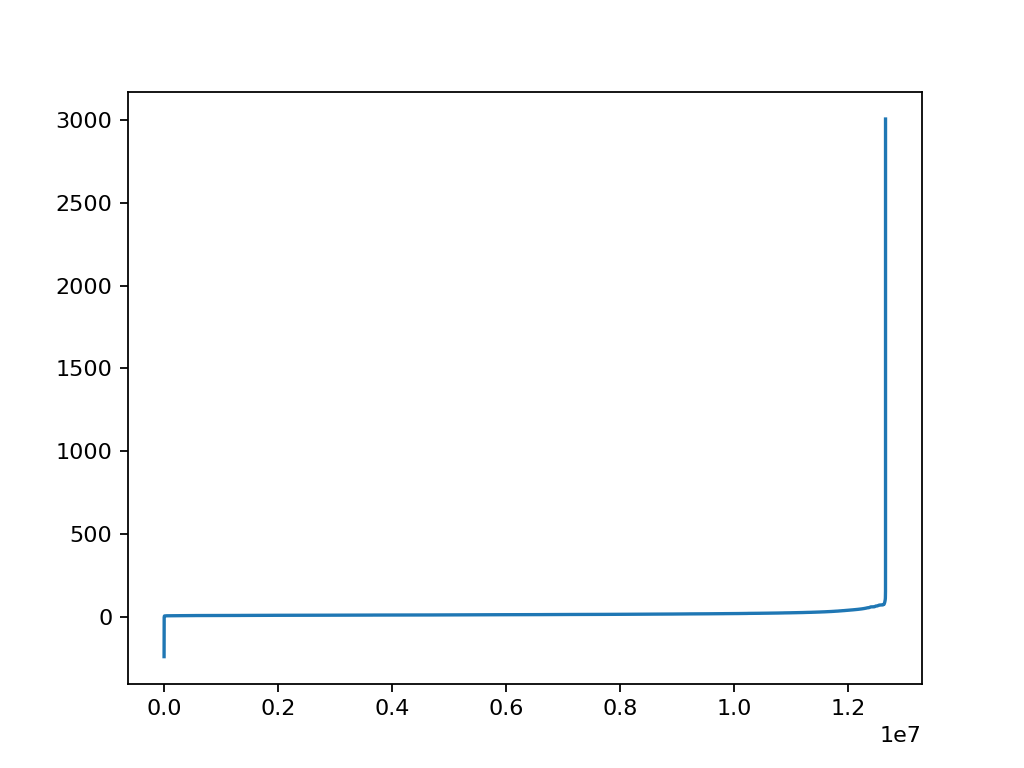

In [55]:
plt.plot(var[:-2])
plt.show()

<IPython.core.display.Javascript object>


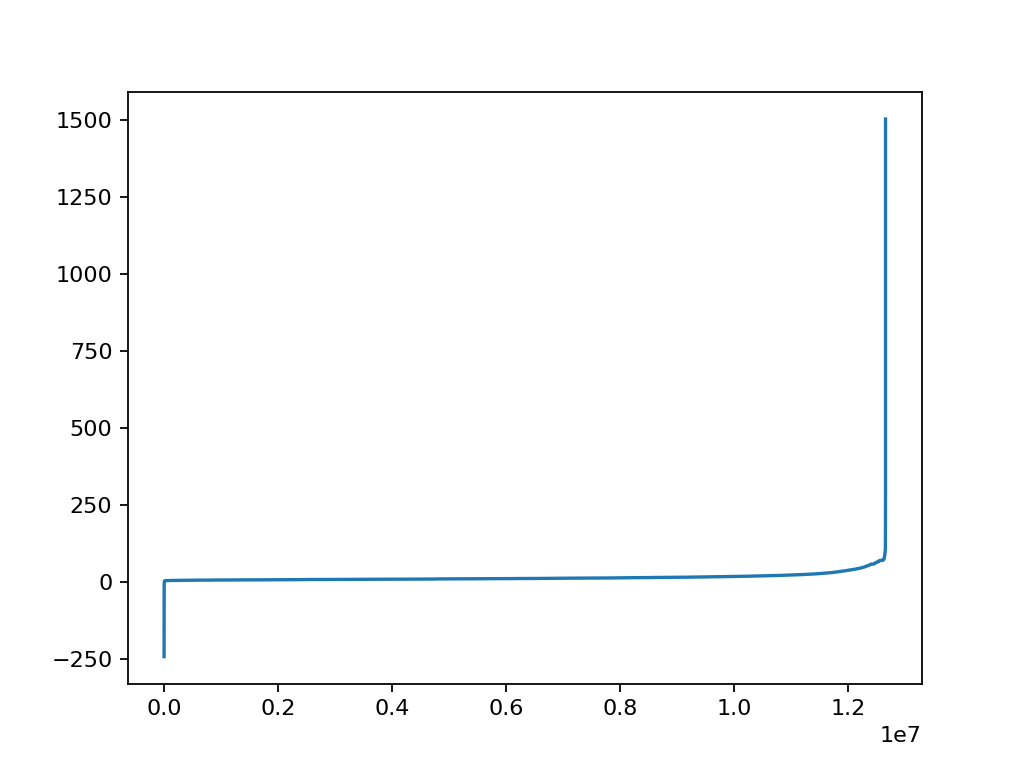

In [56]:
plt.plot(var[:-3])
plt.show()

<IPython.core.display.Javascript object>


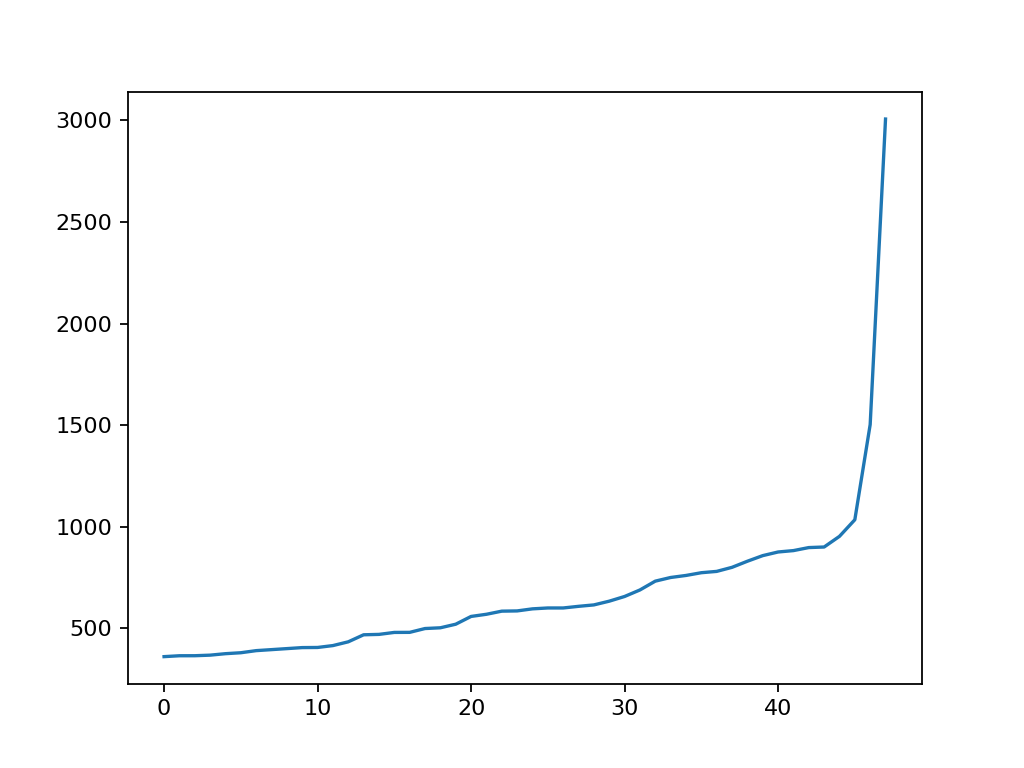

In [57]:
plt.plot(var[-50:-2])
plt.show()

In [58]:
## 아웃라이어 제거

## 아웃라이어를 제거하는 함수 만들기

In [59]:
df_taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'operation_time',
       'operation_second', 'operation_min', 'speed', 'pickup_times'],
      dtype='object')

In [85]:
## 필요없는 특성 제거
df_taxi_modified = df_taxi[['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_amount', 'operation_min','speed','pickup_times']]


### 아웃라이어 제거 하나씩 체크해보기

In [86]:
data_of_number = df_taxi_modified.shape[0]
print("선택한 데이터의 수", data_of_number)

선택한 데이터의 수 12748986


In [87]:
temp_data = df_taxi_modified[((df_taxi_modified['dropoff_longitude'] >= -74.15) & (df_taxi_modified['dropoff_longitude'] <= -73.7004) &\
                                 (df_taxi_modified['dropoff_latitude'] >= 40.5774) & (df_taxi_modified['dropoff_latitude'] <= 40.9176)) &\
                                 ((df_taxi_modified['pickup_longitude'] >= -74.15) & (df_taxi_modified['pickup_longitude'] <= -73.7004) &\
                                 (df_taxi_modified['pickup_latitude'] >= 40.5774) & (df_taxi_modified['pickup_latitude'] <= 40.9176))]
temp_data_of_number =  temp_data.shape[0]

In [88]:
temp_data_of_number

print ("뉴욕지역을 벗어나는 아웃라이어의 수는",(data_of_number-temp_data_of_number))


뉴욕지역을 벗어나는 아웃라이어의 수는 293919


In [89]:
temp_data = df_taxi_modified[(df_taxi_modified['operation_min'] >0) & (df_taxi_modified['operation_min'] < 720)]
b = temp_data.shape[0]
print("택시운행시간을 분석해봤을 때 아웃라이어의 수는", (data_of_number-b))

택시운행시간을 분석해봤을 때 아웃라이어의 수는 23889


In [90]:
temp_data = df_taxi_modified[(df_taxi_modified['trip_distance'] >0) & (df_taxi_modified['trip_distance'] < 23)]
c = temp_data.shape[0]
print("택시운행거리를 분석해봤을 때 아웃라이어의 수는", (data_of_number-c))

택시운행거리를 분석해봤을 때 아웃라이어의 수는 92597


In [91]:
temp_data = df_taxi_modified[(df_taxi_modified['speed'] >=0) & (df_taxi_modified['speed'] <= 65)] ## 100까지
d = temp_data.shape[0]
print("택시운행속도 분석해봤을 때 아웃라이어의 수는", (data_of_number-d))

택시운행속도 분석해봤을 때 아웃라이어의 수는 24473


In [92]:
temp_data = df_taxi_modified[(df_taxi_modified['total_amount'] >0) & (df_taxi_modified['total_amount'] < 1000)] ## 1000달러까지
e = temp_data.shape[0]
print("택시요금 분석해봤을 때 아웃라이어의 수는", (data_of_number-e))

택시요금 분석해봤을 때 아웃라이어의 수는 5275


In [93]:
data_of_number-df_taxi_modified.shape[0]

0

In [542]:
#지금까지 데이터 시각화를 통해 확인한 아웃라이어들을 정리하는 함수를 만든다.

def remove_outliers(df_taxi_modified):
    data_of_number = df_taxi_modified.shape[0]
    print("선택한 데이터의 수", data_of_number)
    
    
    temp_data = df_taxi_modified[((df_taxi_modified['dropoff_longitude'] >= -74.15) & (df_taxi_modified['dropoff_longitude'] <= -73.7004) &\
                                 (df_taxi_modified['dropoff_latitude'] >= 40.5774) & (df_taxi_modified['dropoff_latitude'] <= 40.9176)) &\
                                 ((df_taxi_modified['pickup_longitude'] >= -74.15) & (df_taxi_modified['pickup_latitude'] >= 40.5774) &\
                                 (df_taxi_modified['pickup_longitude'] <= -73.7004) & (df_taxi_modified['pickup_latitude'] <= 40.9176))]
    
    a =  temp_data.shape[0]
    print("뉴욕지역을 벗어나는 아웃라이어의 수는", (data_of_number-a))
    
    temp_data = df_taxi_modified[(df_taxi_modified['operation_min'] >0) & (df_taxi_modified['operation_min'] < 720)]
    b = temp_data.shape[0]
    print("택시운행시간을 분석해봤을 때 아웃라이어의 수는", (data_of_number-b))
    
    temp_data = df_taxi_modified[(df_taxi_modified['trip_distance'] >0) & (df_taxi_modified['trip_distance'] < 23)]
    c = temp_data.shape[0]
    print("택시운행거리를 분석해봤을 때 아웃라이어의 수는", (data_of_number-c))
    
    temp_data = df_taxi_modified[(df_taxi_modified['speed'] >0) & (df_taxi_modified['speed'] < 45.31)] 
    d = temp_data.shape[0]
    print("택시운행속도 분석해봤을 때 아웃라이어의 수는", (data_of_number-d))
    
    temp_data = df_taxi_modified[(df_taxi_modified['total_amount'] >0) & (df_taxi_modified['total_amount'] < 1000)] ## 1000달러까지
    e = temp_data.shape[0]
    print("택시요금 분석해봤을 때 아웃라이어의 수는", (data_of_number-e))
    
    
    df_taxi_modified = df_taxi_modified[((df_taxi_modified['dropoff_longitude'] >= -74.15) & (df_taxi_modified['dropoff_longitude'] <= -73.7004) &\
                                 (df_taxi_modified['dropoff_latitude'] >= 40.5774) & (df_taxi_modified['dropoff_latitude'] <= 40.9176)) &\
                                 ((df_taxi_modified['pickup_longitude'] >= -74.15) & (df_taxi_modified['pickup_longitude'] <= -73.7004) &\
                                 (df_taxi_modified['pickup_latitude'] >= 40.5774) & (df_taxi_modified['pickup_latitude'] <= 40.9176))]
    
    df_taxi_modified = df_taxi_modified[(df_taxi_modified['operation_min'] >0) & (df_taxi_modified['operation_min'] < 720)]
    
    df_taxi_modified = df_taxi_modified[(df_taxi_modified['trip_distance'] >0) & (df_taxi_modified['trip_distance'] < 23)]
    
    df_taxi_modified = df_taxi_modified[(df_taxi_modified['speed'] >0) & (df_taxi_modified['speed'] <45.31)]
    
    df_taxi_modified = df_taxi_modified[(df_taxi_modified['total_amount'] >0) & (df_taxi_modified['total_amount'] < 1000)]
    
    print("총 제거된 아웃라이어의 수는", data_of_number-df_taxi_modified.shape[0])
    print("----")
    
    return  df_taxi_modified
    
    
    
    
    

In [543]:
## 아웃라이어 제거하고 체크해보기 
print("2015년 1월 제거된 아웃라이어")
print("-----")
df_taxi_data_outliers_removed = remove_outliers(df_taxi_modified)
print("아웃라이어 제거 후에 남겨진 데이터의 비율은", float(len(df_taxi_data_outliers_removed))/len(df_taxi_modified))

2015년 1월 제거된 아웃라이어
-----
선택한 데이터의 수 12748986
뉴욕지역을 벗어나는 아웃라이어의 수는 293919
택시운행시간을 분석해봤을 때 아웃라이어의 수는 23889
택시운행거리를 분석해봤을 때 아웃라이어의 수는 92597
택시운행속도 분석해봤을 때 아웃라이어의 수는 101830
택시요금 분석해봤을 때 아웃라이어의 수는 5275
총 제거된 아웃라이어의 수는 377910
----
아웃라이어 제거 후에 남겨진 데이터의 비율은 0.9703576425607495


# 데이터 준비하기

## 클러스터링과 분할

In [544]:
## K-means clustering으로 해본다.
#주어진 데이터들이 얼마나, 어떻게 유사한지 확인
from sklearn.cluster import MiniBatchKMeans, KMeans # 클러스터링
import gpxpy.geo 



In [645]:
## 클러스터의 수 K를 구하기 위해서 다양한 크기에 클러스터링을 시도한다. 
coords = df_taxi_data_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    good_points = 0
    bad_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        good_points = 0
        bad_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1], cluster_centers[j][0], cluster_centers[j][1]) ##체크
                min_dist = min(min_dist, distance/(1.60934*1000))
                if(distance/(1.60934*1000)) <= 2:
                    good_points +=1
                else:
                    bad_points +=1
        less2.append(good_points)
        more2.append(bad_points)
    neighbours.append(less2)
    print("클러스터 크기 선택", cluster_len, "/nAvg 주변 클러스터의 수 (클러스터간의 거리 < 2):", np.ceil(sum(less2)/len(less2)), "/nAvg. 주변 클러스터의 수 (클러스터간의 거리 < 2):", np.ceil(sum(more2)/len(more2)),"\nMin 클러스터간의 거리 = ",min_dist,"\n---")
    
    

In [546]:
## 클러스터를 찾는 함수
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size = 10000, random_state=42).fit(coords)
    df_taxi_data_outliers_removed['pickup_cluster'] = kmeans.predict(df_taxi_data_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len



In [547]:
## 클러스터 수를 구해야 한다.
## 클러스터 센터와 데이터 간에는 가까워야한다. 
## 최소의 클러스터 간의 거리가 너무 작지 않아야 한다.
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of 10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.0945442325142662 
---
On choosing a cluster size of 20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.7131298007388065 
---
On choosing a cluster size of 30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance =  0.5185088176172186 
---
On choosing a cluster size of 40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter-cluster distance =  0

In [548]:
## k값이 50개 클러스터를 했을 경우, 0.3 마일 밖에 떨어지지 않는다.
## k값이 40개 클러스터를 했을 경우, 0.5 마일 정도 떨어져있기 때문에 선택한다. 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
df_taxi_data_outliers_removed['pickup_cluster'] = kmeans.predict(df_taxi_data_outliers_removed[['pickup_latitude', 'pickup_longitude']])

In [549]:
## 지도에 표시해보기
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], titles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0], cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)

map_osm

In [550]:
## 클러스터링 plotting 해보기
def plot_clusters(data):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(data['pickup_longitude'].values[:100000], data['pickup_latitude'].values[:100000], s=10, lw=0,
              c=data['pickup_cluster'].values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
    


<IPython.core.display.Javascript object>


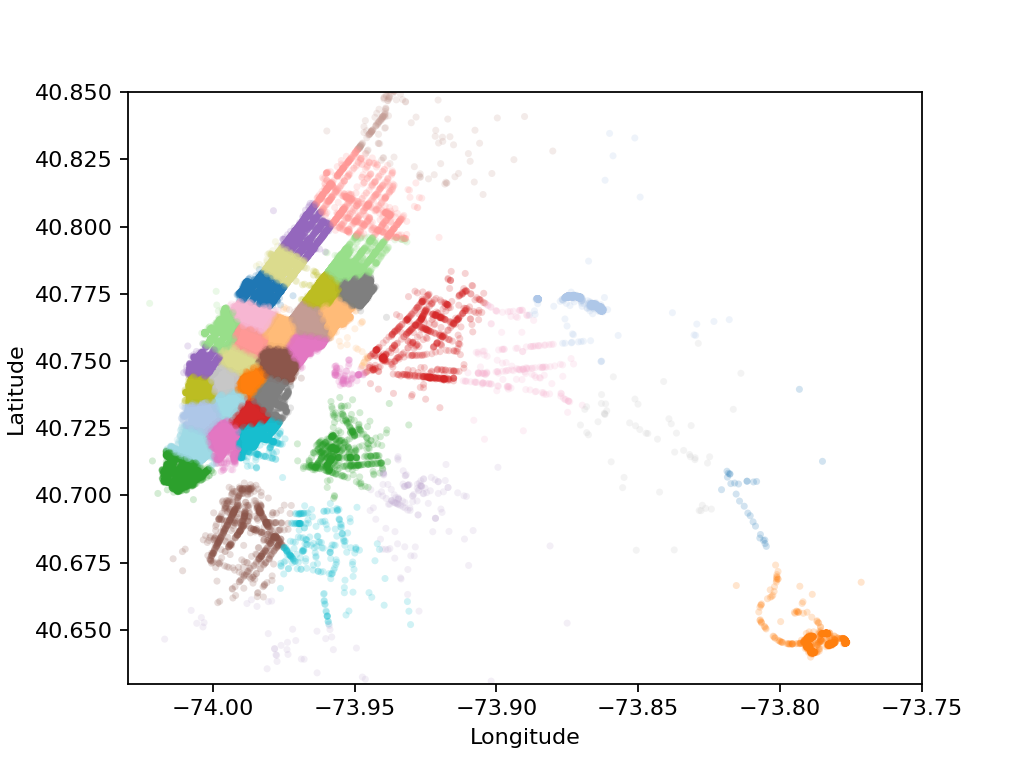

In [551]:
plot_clusters(df_taxi_data_outliers_removed)

In [ ]:
## 대략적인 클러스터의 모습을 볼 수 있다. 

In [576]:
## 10분단위로 데이터를 구분하여 클러스터에 맞춰 넣는다.

#참조 :https://www.unixtimestamp.com/
# 1420070400 : 2015-01-01 00:00:00 
# 1422748800 : 2015-02-01 00:00:00 
# 1425168000 : 2015-03-01 00:00:00
# 1427846400 : 2015-04-01 00:00:00 
# 1430438400 : 2015-05-01 00:00:00 
# 1433116800 : 2015-06-01 00:00:00

# 1451606400 : 2016-01-01 00:00:00 
# 1454284800 : 2016-02-01 00:00:00 
# 1456790400 : 2016-03-01 00:00:00
# 1459468800 : 2016-04-01 00:00:00 
# 1462060800 : 2016-05-01 00:00:00 
# 1464739200 : 2016-06-01 00:00:00
def add_pickup_bins(data, month, year):
    unix_pickup_times = [i for i in data['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    
    ## unix time을 gmt을 통해 qusghksgksek. 
    start_pickup_unix=unix_times[year-2015][month-1]
    
    ## 이해필요
    tenminutewise_binned_unix_pickup_times = [(int((i-start_pickup_unix)/600+54)) for i in unix_pickup_times]
    data['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return data                                          

In [577]:
# pickup bin, pickup 클러스트를 기준으로  픽업 빈별 그룹화 한다. 
df_taxi_data_outliers_removed['pickup_cluster'] = kmeans.predict(df_taxi_data_outliers_removed[['pickup_latitude', 'pickup_longitude']])
jan_2015_data = add_pickup_bins(df_taxi_data_outliers_removed, 1, 2015)
jan_2015_groupby = jan_2015_data[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [578]:
# 'pickup_cluster' / 'pickup_bins'(10분 내) 두개의 열을 추가했다. 
jan_2015_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  operation_min  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

       speed  pickup_times  pickup_cluster  pickup_bins  
0   5.285319  1.421316e+09              34         2130  
1   9.983193  1.420890e+09               2         1419  
2  10.746269  1.420890e+09              16         1419  
3  16.071429  1.420890e+09              38         1419  
4   9.318378  1.420890e+09              22         1419

In [579]:
## 여기서 trip_distance는 운행 중 특정 10분동안 발생한 픽업의 수를 나타냄
## 두개의 인덱스가 있는데, 
## pickup_cluster(클러스터 번호), 
## pickup_bin(전체 월 시간 10분 간격으로 나눠 31*24*60/10 = 4464로 구분)
jan_2015_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              0                      104
               1                      200
               2                      208
               3                      141
               4                      155

In [580]:
## 데이터들을 가져 온다. 

month_jan_2016 = pd.read_csv('yellow_tripdata_2016-01.csv')
month_jan_2016_d = dd.read_csv('yellow_tripdata_2016-01.csv')
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

In [581]:
## 데이터에서 칼럼 뽑아내고, 변환시킨다. passenger_count/trip_distance/pickup_longitude/pickup_latitude/dropoff_longitude/dropoff_latitude/total_amount/trip_times/pickup_times/Speed 

def return_with_trip_times(data):
    duration = data[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    #unix_time으로 변환
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    ## 운행시간 계산
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    
    ## 새로운 데이터 프레임 뽑아냄
    new_data = data[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_data['operation_min'] = durations
    new_data['pickup_times'] = duration_pickup
    new_data['speed'] = (new_data['trip_distance'] / new_data['operation_min'])*60
        
    return new_data

In [311]:
#month_jan_2016_data = return_with_trip_times(month_jan_2016_d)

In [646]:
## 2016년 데이터를 정리해본다. 
### 2016/1,2,3월에 대해서 동일한 작업을 진행
### 필요한 열의 데이터만 가져오고
### trip_time의 trip time, speed, unix time stamp 추가
### trip_times, speed, trip_times, total_mount 이상치 제거
### 각 데이터에 pickup_cluster 추가
### pickup_bin 추가(운행시간에 속한 구간 10분)
### 'cluster_cluster' 및 'picuo_bin'을 기반으로 데이터별로 그룹화

def datapreparation(data, kmeans, month_no, year_no):
    
    print("운행시간..")
    
    preparation_data = return_with_trip_times(data)
    
    print("이상치 제거..")
    
    data_outliers_removed = remove_outliers(preparation_data)
    
    print("클러스터 추정..")
    
    data_outliers_removed["pickup_cluster"] = kmeans.predict(data_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    
    print("최종 그룹핑..")
    final_updated_data = add_pickup_bins(data_outliers_removed, month_no, year_no)

    final_groupby_data = final_updated_data[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_data, final_groupby_data  

In [647]:

jan_2016_data, jan_2016_groupby = datapreparation(month_jan_2016_d,kmeans,1,2016)
feb_2016_frame,feb_2016_groupby = datapreparation(month_feb_2016,kmeans,2,2016)
mar_2016_frame,mar_2016_groupby = datapreparation(month_mar_2016,kmeans,3,2016)


운행시간..


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

## 평활화

In [314]:
## 평활화(smoothing)
## 시간대에 데이터가 존재하지 않을 경우, 이 때 0으로 채워주고 평균값으로 데이터르 평활화한다.
## 예측 효율을 높여주기 위해서 쓰고, 큰 트렌드를 맞출 수 있다. 

In [582]:
## 각 지역에 대한 pickup 값이 있는 고유한 빈을 가져온다.
## 각 클러스터 영역ㄱ에 대해 픽업이 발생하는 10분단위의 모든 인덱스를 수집한다. 

def return_unq_pickup_bins(data):
    values = []
    for i in range(0,40):
        new = data[data['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [583]:
#1월
jan_2015_unique = return_unq_pickup_bins(jan_2015_data)
jan_2016_unique = return_unq_pickup_bins(jan_2016_data)

#2월
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)

#3월
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [584]:
# pickup이 0인 10분간격의 클러스터 번호


for i in range(40):
    print(i, "픽업이 0인 이동거리 10분이내의 클러스터", 4464- len(set(jan_2015_unique[i])))
    print('-'*60)


0 픽업이 0인 이동거리 10분이내의 클러스터 40
------------------------------------------------------------
1 픽업이 0인 이동거리 10분이내의 클러스터 1985
------------------------------------------------------------
2 픽업이 0인 이동거리 10분이내의 클러스터 29
------------------------------------------------------------
3 픽업이 0인 이동거리 10분이내의 클러스터 354
------------------------------------------------------------
4 픽업이 0인 이동거리 10분이내의 클러스터 37
------------------------------------------------------------
5 픽업이 0인 이동거리 10분이내의 클러스터 153
------------------------------------------------------------
6 픽업이 0인 이동거리 10분이내의 클러스터 34
------------------------------------------------------------
7 픽업이 0인 이동거리 10분이내의 클러스터 34
------------------------------------------------------------
8 픽업이 0인 이동거리 10분이내의 클러스터 117
------------------------------------------------------------
9 픽업이 0인 이동거리 10분이내의 클러스터 40
------------------------------------------------------------
10 픽업이 0인 이동거리 10분이내의 클러스터 25
------------------------------------------------------------
11 픽

In [585]:
## pickupdata가 없는 모든 bin에 대해 0으로 채우기 
## count_values는 깍 영역 내에서 10분마다 발생하는 pickuptn
## values: 고유한 bin 수

## 10분마다 고유한 bin을 확인
## count_values[index]를 평활 데이터에 추가


def fill_missing(count_values, values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [586]:
## 
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역의 최종 평활화값 목록 저장
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] # 최종 평활화값 저장
        repeat=0
        for i in range(4464):
            if repeat!=0: # 반복값을 방지
                repeat-=1
                continue
            if i in values[r]: #pickup_bin 확인
                smoothed_bins.append(count_values[ind]) #pickup bin 값이 있다면 추가
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #pickup-bin 값 혹은 왼쪽 제한이 있는 pickup 값을 검색
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: 마지막 몇개의 값이 missing 값이 확인되면 이에 대한 right-limit 없다.
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: 알고있는 두 값 사이에 missing 값이 있는 경우
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 첫 번째 몇개의 값이 missing 값으로 확인 될 때, left-limit가 없다. 
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [587]:
## 2015년 1월 결측값 0 채우기
## jan_2015_groupby dataframe의 trip_distance는 발생한 픽업수를 나타냄 
import math
jan_2015_fill = fill_missing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)


## 2015년 1월 결측값 평활화
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)


In [648]:
## 각 군집마다 4464개의 값이 있으므로 40*4464 = 178560개의 값
print("모든 클러스터 사이의 10분 간격 수 ",len(jan_2015_fill))

모든 클러스터 사이의 10분 간격 수  178560


<IPython.core.display.Javascript object>


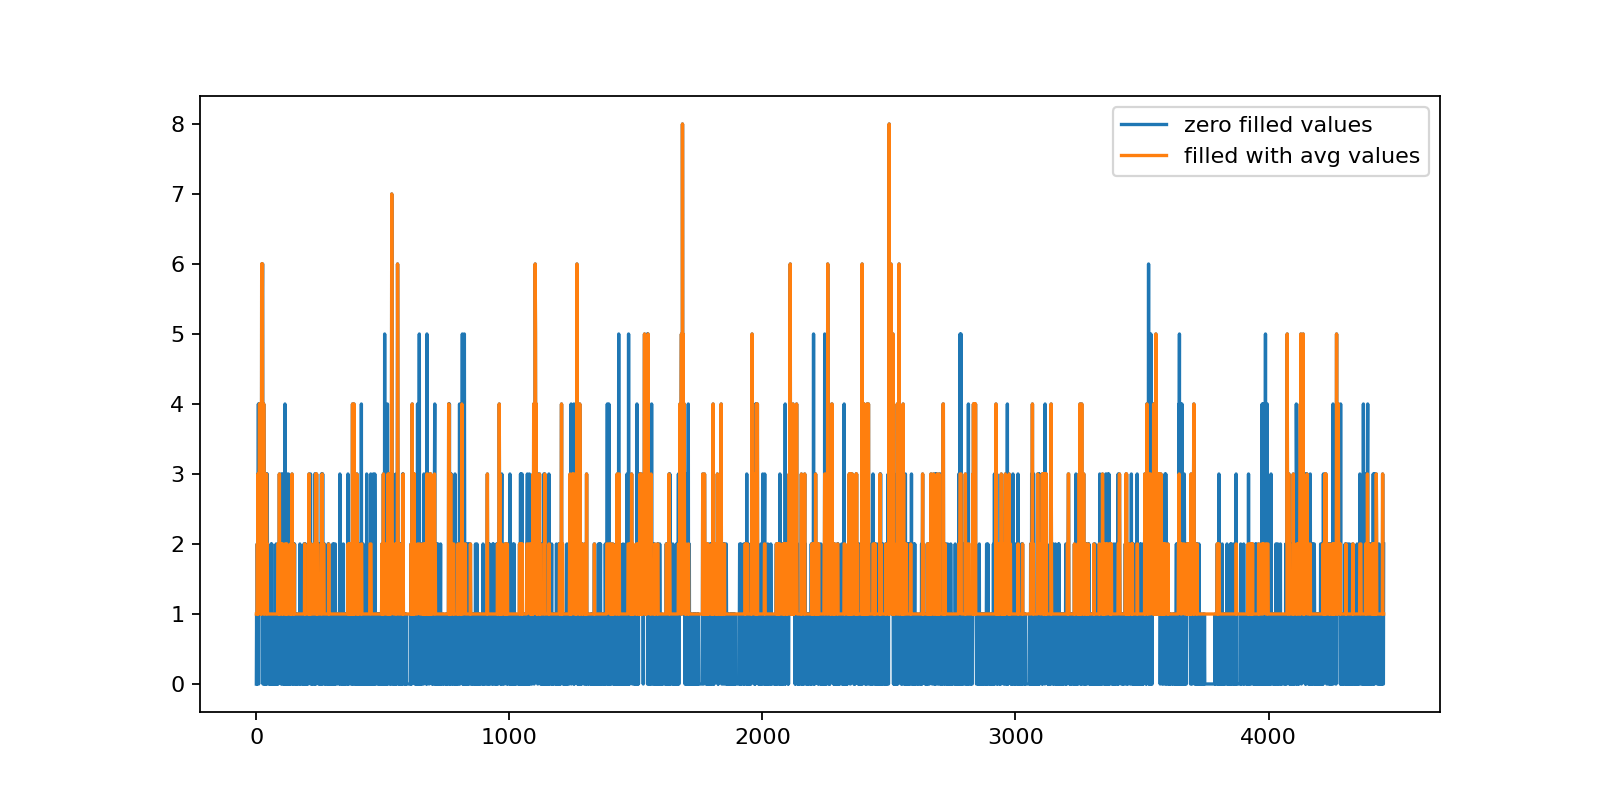

In [590]:
## 확인해보자
plt.figure(figsize=(10,5))
plt.plot(jan_2015_fill[4464:8920], label="zero filled values")
plt.plot(jan_2015_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [591]:
## 우리가 선택한 이유, 이 방법들, 그리고 어떤 방법이 어떤 데이터에 사용되는가?

# Ans: 2015년 1월 1일, 10일, 20일, 즉 1일에 10건의 픽업 데이터가 있다고 가정
# 10번째 10분, 0번째 10분, 0번째 10분, 3번째 10분, 0번째 10분, 20개의 픽업은 4번째 10분 안에 이루어졌습니다.
# fill_missing method에서는 10, 0, 0, 20과 같은 값을 대체
# 여기서 평활법에서와 같이 픽업 횟수를 확인할 수 있는 경우 6,6,6,6,6으로 값을 대체
# 처음 40분 동안 일어나는 일은 두 경우 모두 동일하지만, 만약 당신이 우리가 미래 가치를 보는 것을 관찰할 수 있다면
# 스무딩 사용 시 데이터 누출의 원인이 될 수 있는 향후 픽업 횟수를 살펴봅니다.

# 따라서 2015년 1월 데이터에는 교육 데이터 역할을 하므로 스무딩을 사용, 2016년 데이터에는 단순 fill_missing 방법을 사용합니다.

## 2015년 1월~2015년 1월, 2월, 3월 데이터 누락은 0으로 채워짐
jan_2015_smooth = smoothing(jan_2015_groupby['trip_distance'].values,jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['trip_distance'].values,jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['trip_distance'].values,feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['trip_distance'].values,mar_2016_unique)

In [592]:
## 3개월 동안 모든 빈에 픽업 데이터의 모든 값 목록을 작성하여 지역별로 저장
regions_cum = []
for i in range(0,40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)]+feb_2016_smooth[4176*i:4176*(i+1)]+mar_2016_smooth[4464*i:4464*(i+1)])



<IPython.core.display.Javascript object>


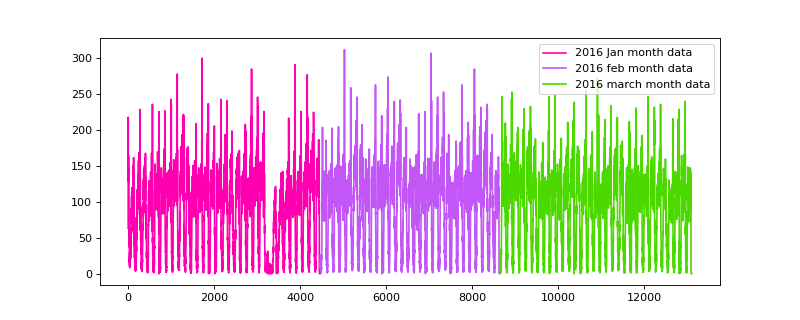

<IPython.core.display.Javascript object>


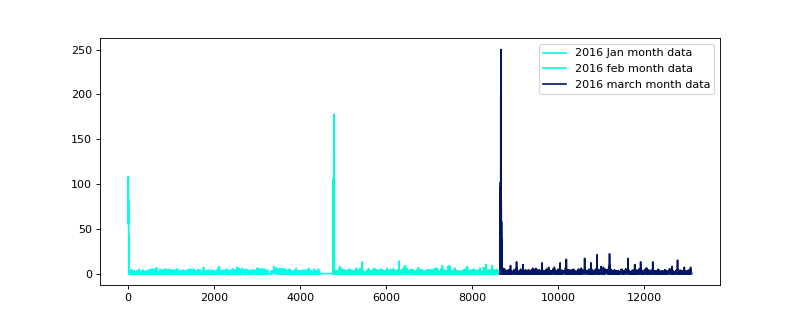

<IPython.core.display.Javascript object>


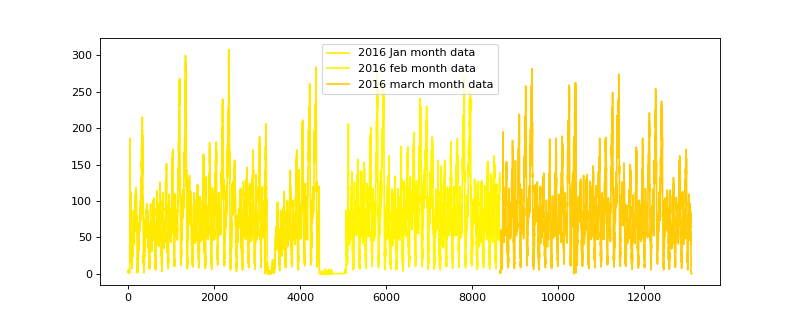

<IPython.core.display.Javascript object>


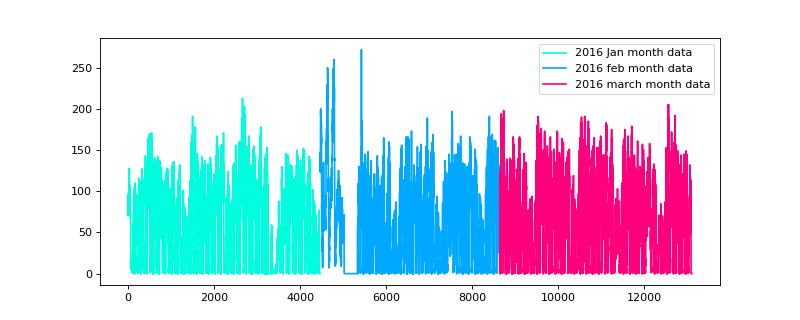

<IPython.core.display.Javascript object>


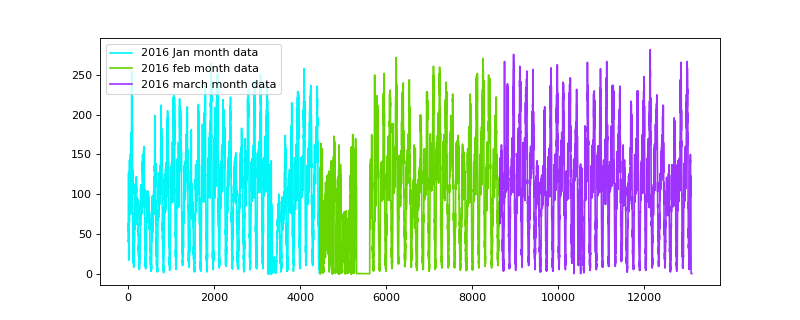

<IPython.core.display.Javascript object>


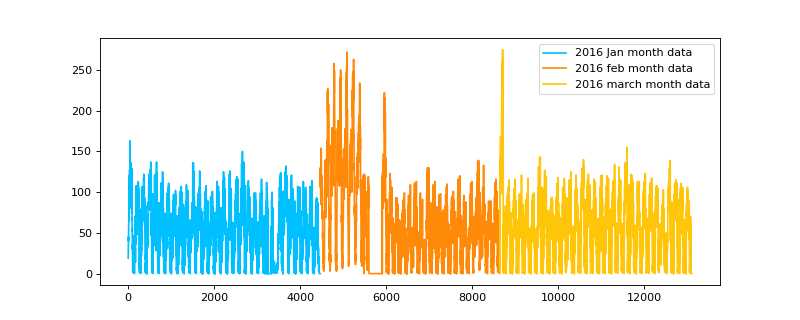

<IPython.core.display.Javascript object>


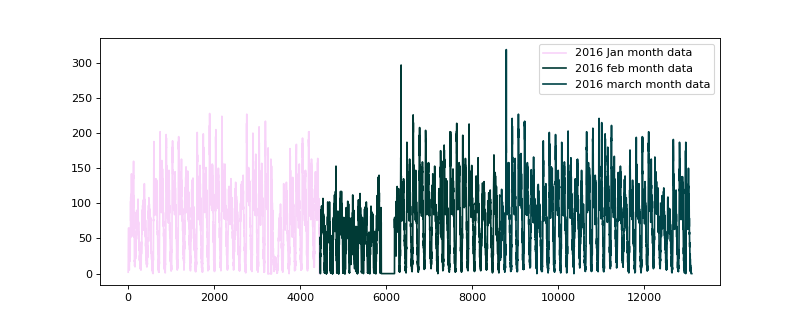

<IPython.core.display.Javascript object>


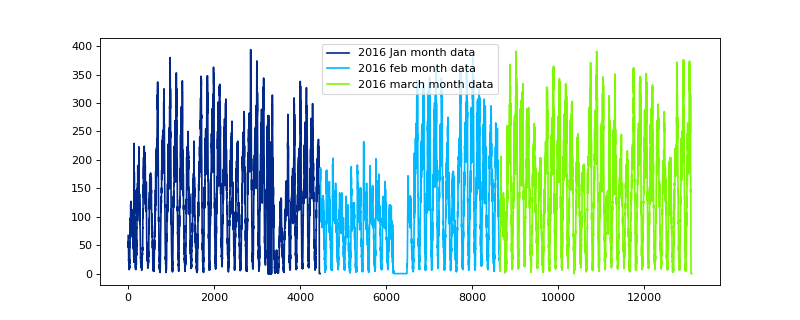

<IPython.core.display.Javascript object>


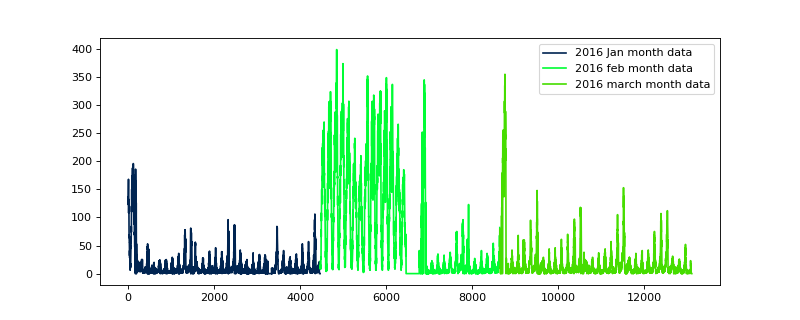

<IPython.core.display.Javascript object>


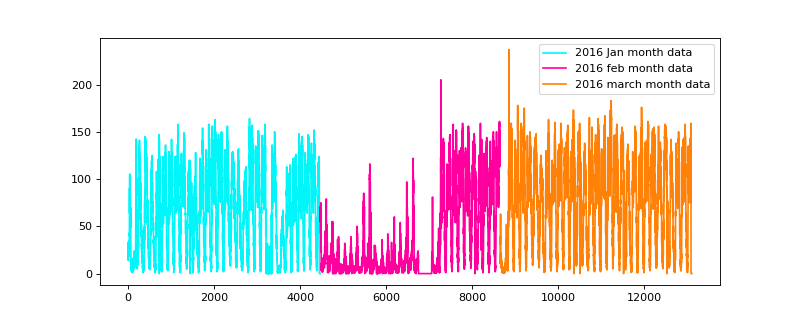

<IPython.core.display.Javascript object>


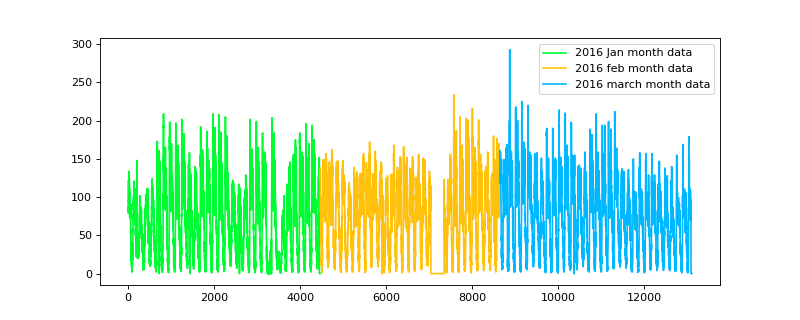

<IPython.core.display.Javascript object>


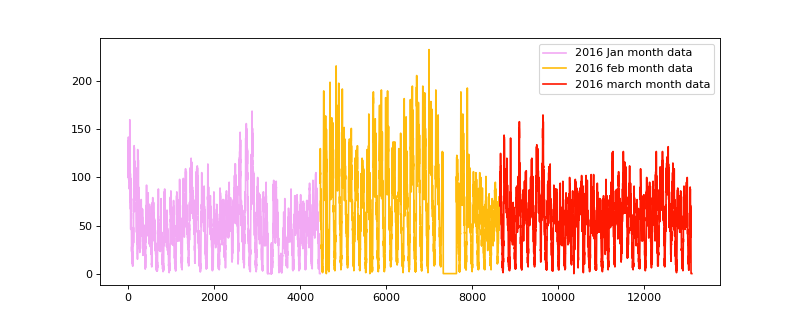

<IPython.core.display.Javascript object>


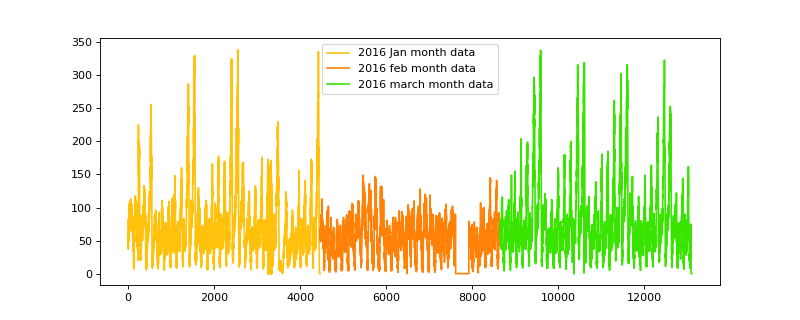

<IPython.core.display.Javascript object>


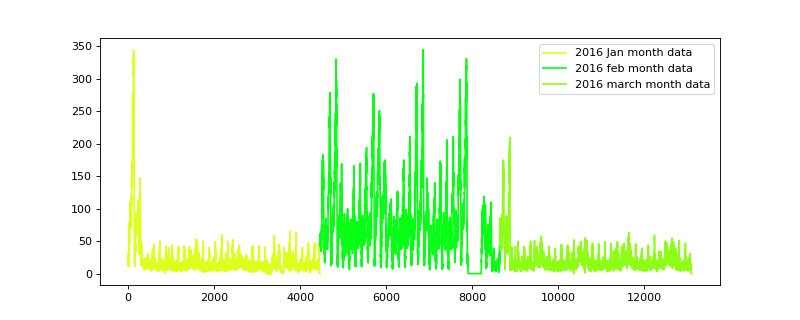

<IPython.core.display.Javascript object>


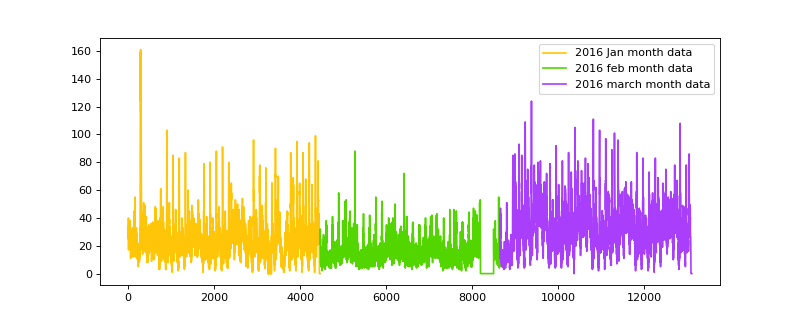

<IPython.core.display.Javascript object>


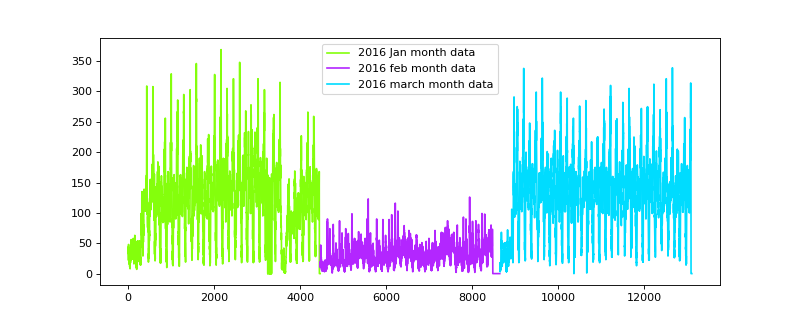

<IPython.core.display.Javascript object>


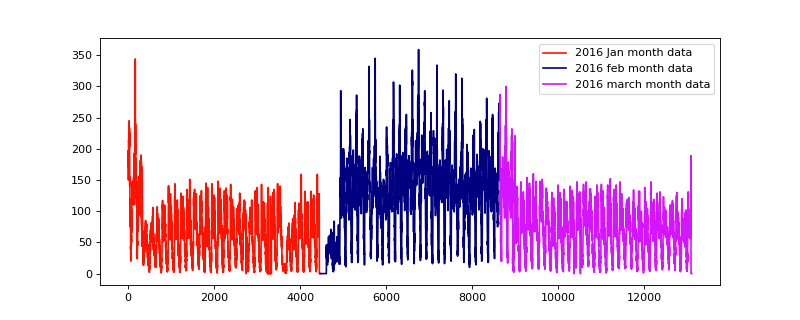

<IPython.core.display.Javascript object>


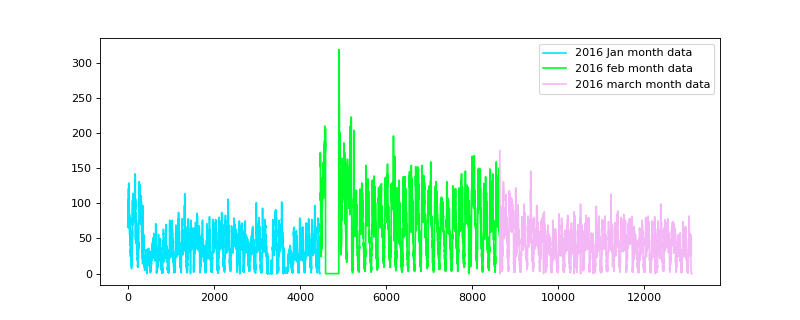

<IPython.core.display.Javascript object>


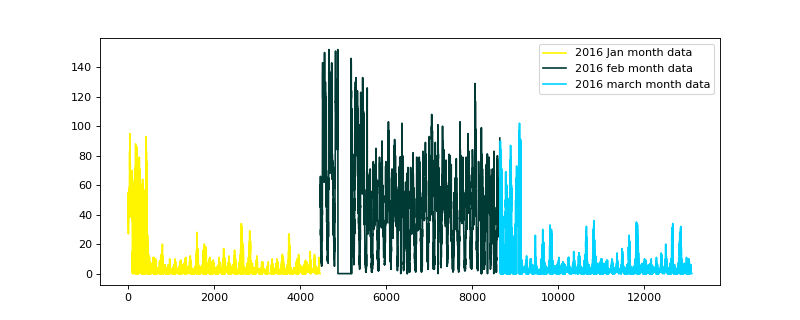

<IPython.core.display.Javascript object>


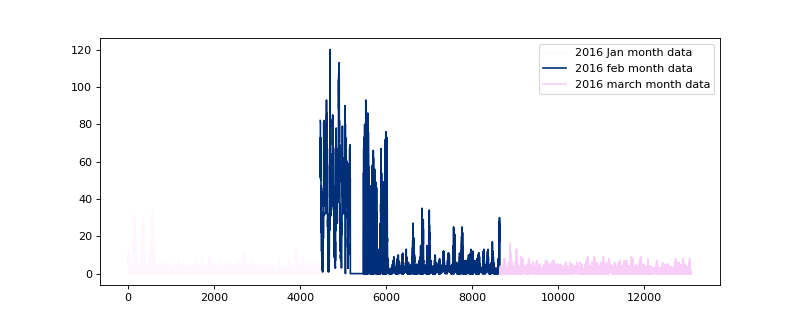

<IPython.core.display.Javascript object>


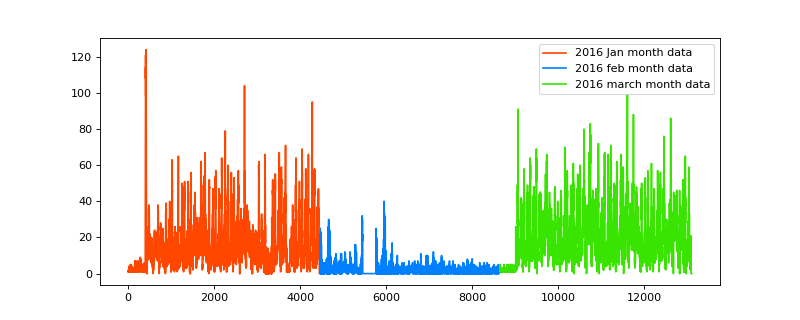

<IPython.core.display.Javascript object>


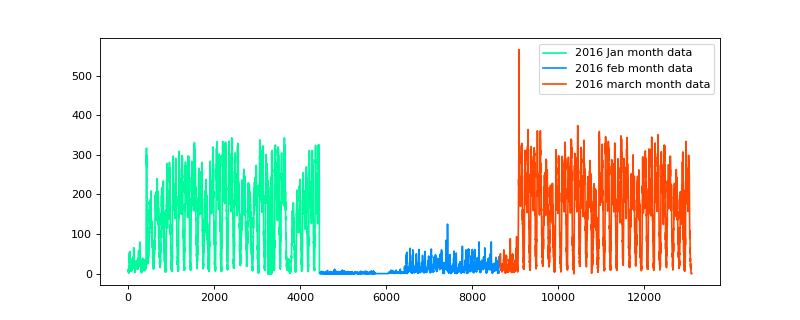

<IPython.core.display.Javascript object>


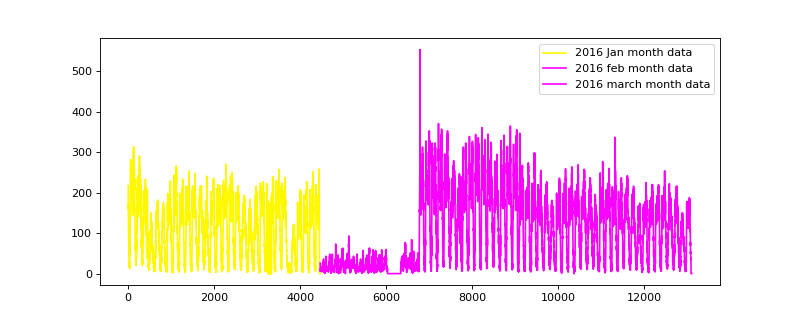

<IPython.core.display.Javascript object>


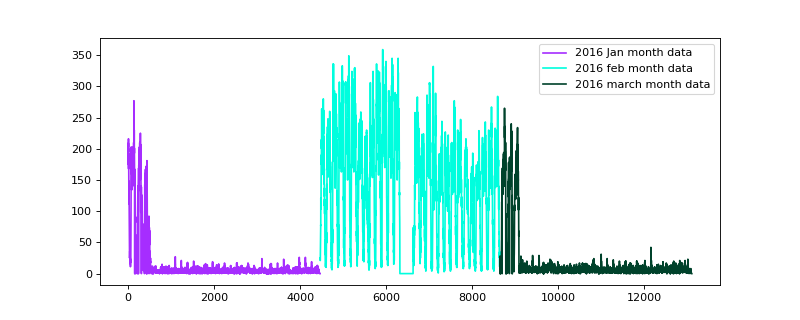

<IPython.core.display.Javascript object>


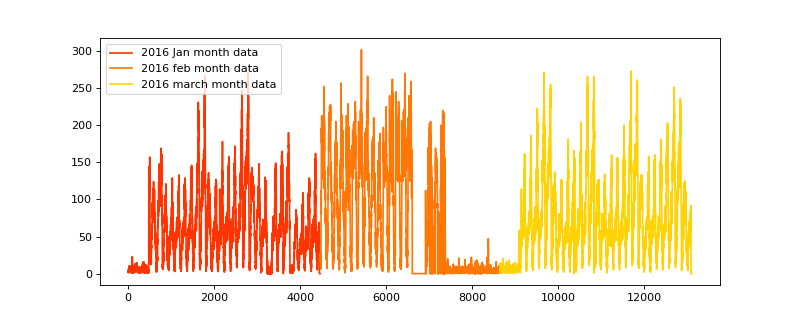

<IPython.core.display.Javascript object>


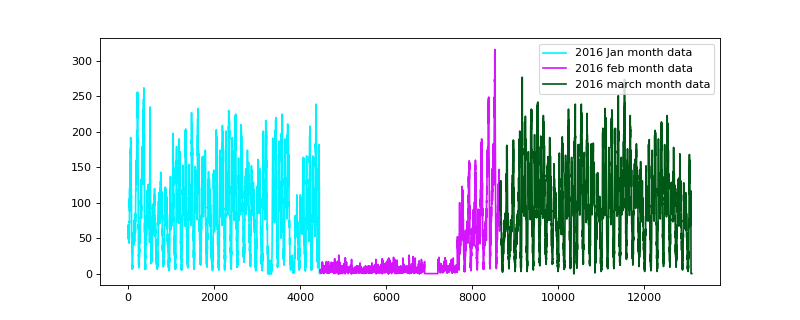

<IPython.core.display.Javascript object>


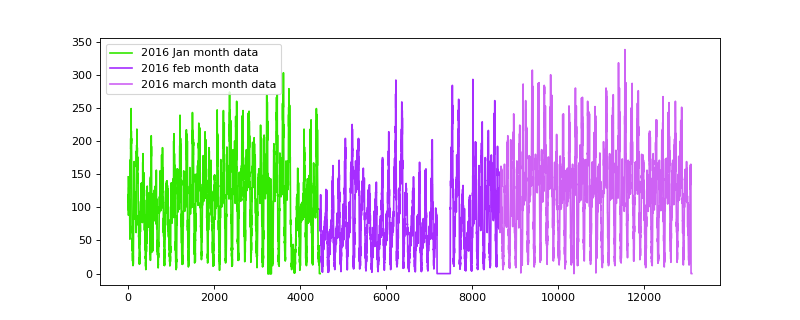

<IPython.core.display.Javascript object>


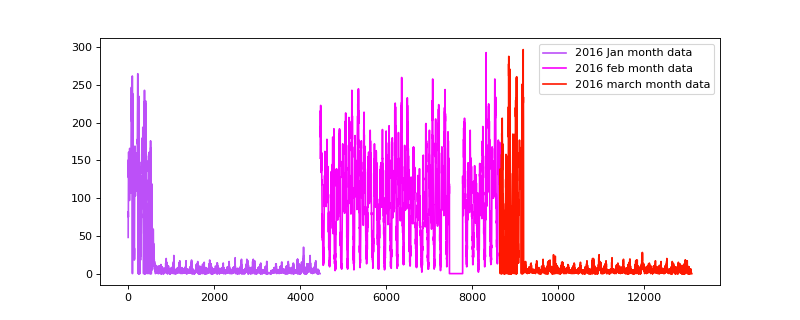

<IPython.core.display.Javascript object>


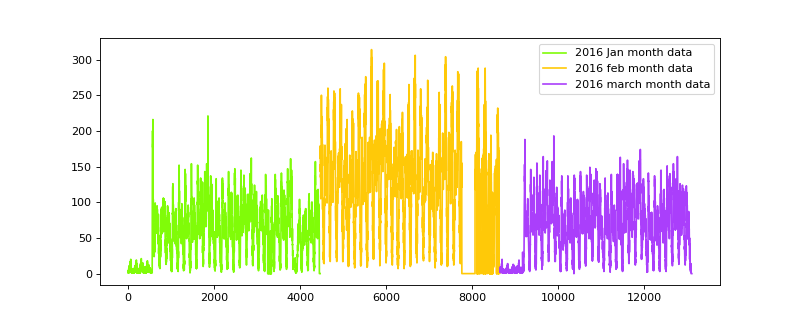

<IPython.core.display.Javascript object>


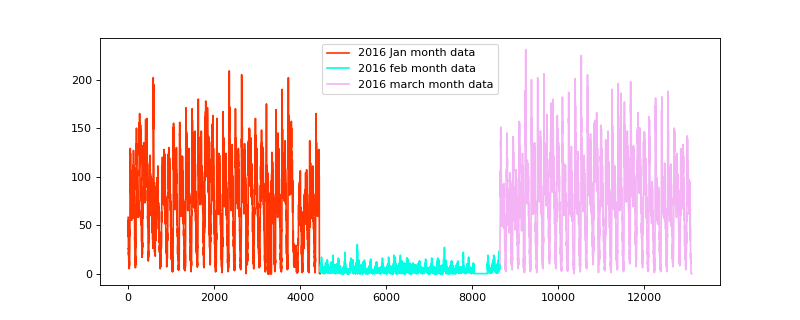

<IPython.core.display.Javascript object>


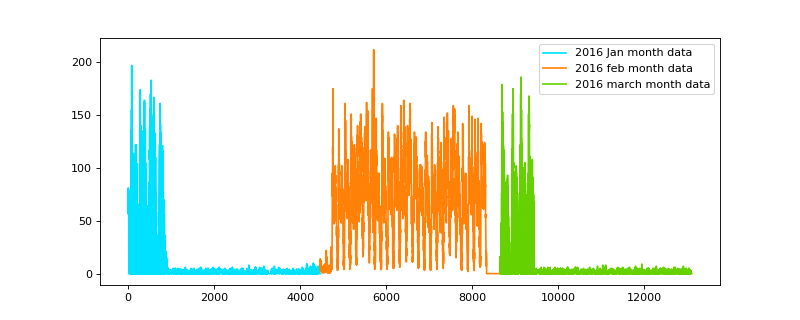

<IPython.core.display.Javascript object>


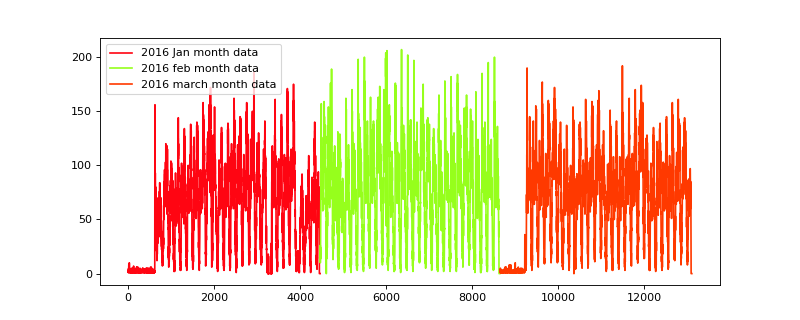

<IPython.core.display.Javascript object>


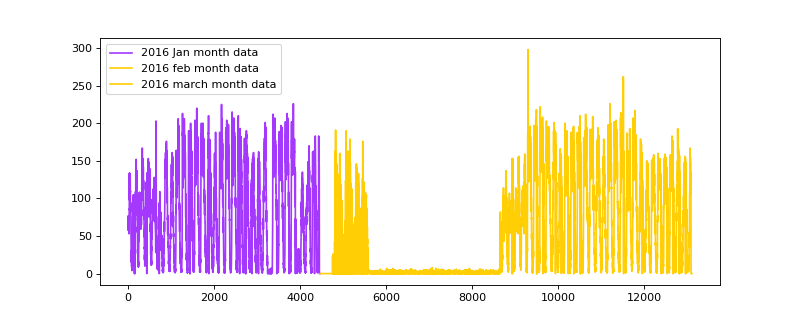

<IPython.core.display.Javascript object>


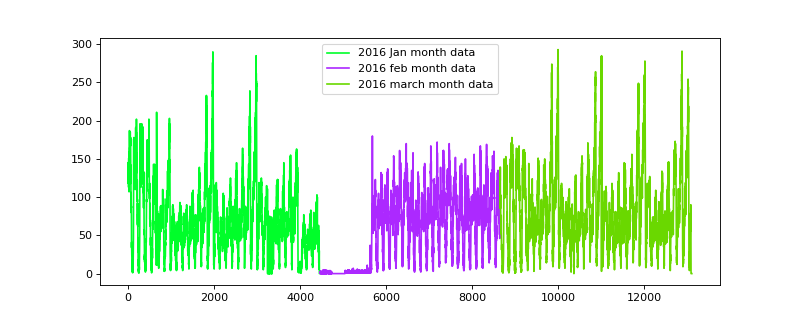

<IPython.core.display.Javascript object>


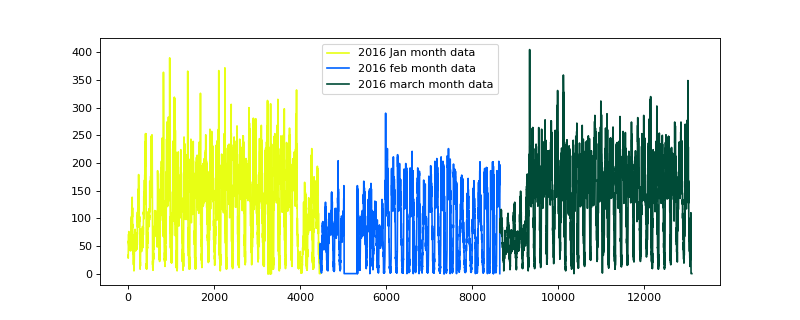

<IPython.core.display.Javascript object>


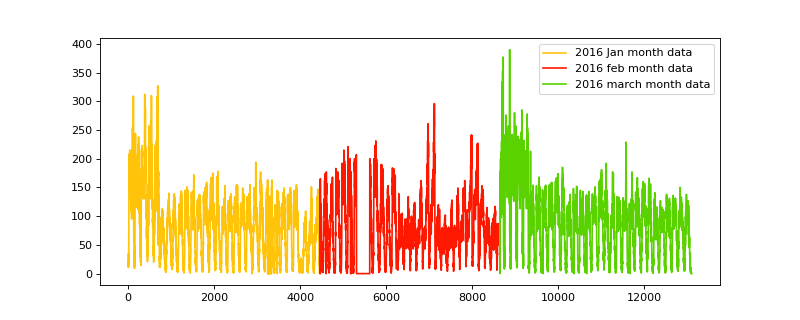

<IPython.core.display.Javascript object>


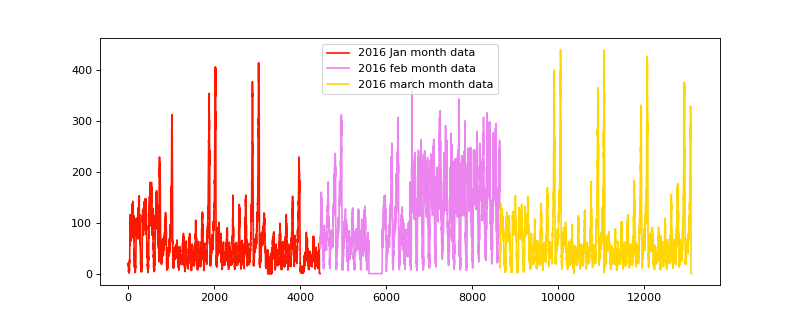

<IPython.core.display.Javascript object>


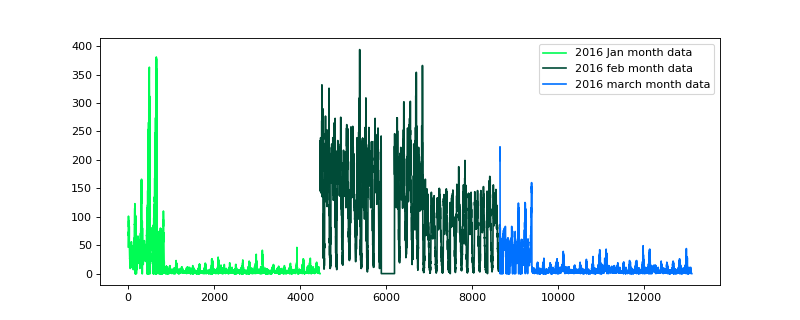

<IPython.core.display.Javascript object>


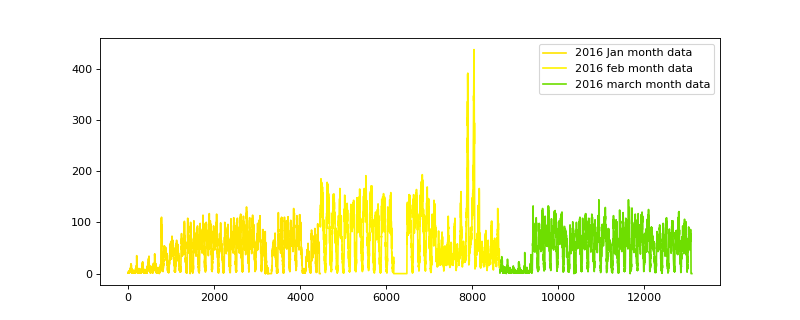

<IPython.core.display.Javascript object>


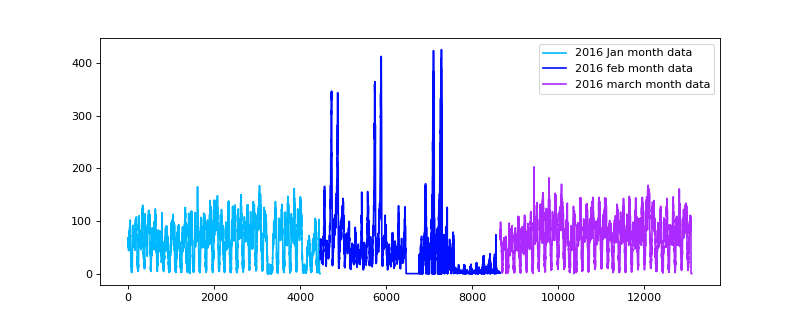

In [593]:


def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2016 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2016 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2016 march month data')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


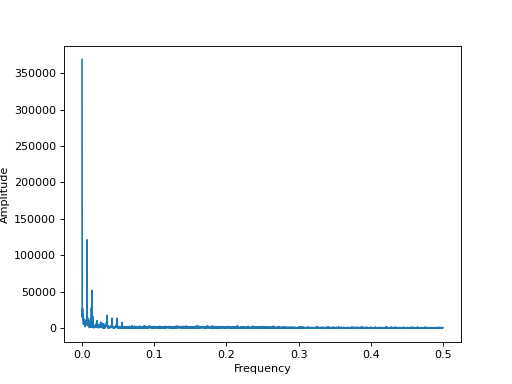

In [594]:
Y    = np.fft.fft(np.array(jan_2016_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [595]:
#데이터프레임 준비는 x(i)값을 2015년 1월 데이터값으로, y(i)값을 2016년 1월 데이터값으로
ratios_jan = pd.DataFrame()
ratios_jan['given']=jan_2015_smooth
ratios_jan['prediction']=jan_2016_smooth
ratios_jan['ratios']=ratios_jan['prediction']*1.0/ratios_jan['given']*1.0

## 기본모델
### 2016년 1월, 2월 및 3월에 대한 픽업 밀도를 예측하기 위해 모델링
### pickup ratio : Rt = 2016년 탑승자 수 / 2015년 탑승자수 
### 예시 Rt  =120/100, 20% 증가를 알 수 있음.
2016년 데이터 대 2015년 데이터 비율
 $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
 
2016년 데이터 자체의 이전 알려진 값을 사용하여 미래 값 예측



## simple moving average 
### 이전 n개의 값을 사용하여 다음 값을 예측하는 평균 모형
### 다음 타임의 비율이, 이전 타임의 평균으로 결정된다.

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$



In [596]:
def S_M_R_predictions(ratios, data):
    predicted_ratio=(ratios['ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['given'].values)[i])*predicted_ratio)-(ratios['prediction'].values)[i],1))))
        
        if i+1>=window_size:
            predicted_ratio=sum((ratios['ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['ratios'].values)[0:(i+1)])/(i+1)
    
    ratios['S_M_R_predicted'] = predicted_values
    ratios['S_M_R_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

$\begin{align}P_{t} = P_{t-1} \end{align}$

In [597]:
def S_M_P_predictions(ratios, data):
    predicted_value=(ratios['prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    ## 바뀜
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['prediction'].values)[i],1))))
        
        if i+1>=window_size:
            predicted_value=int(sum((ratios['prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['prediction'].values)[0:(i+1)])/(i+1))
    
    ratios['S_M_P_predicted'] = predicted_values
    ratios['S_M_P_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

## weighted moving average
### 이동 평균 모델은 미래가 최신 값과 비슷하고 이전 값과 덜 비슷할 가능성이 있다는 것을 직관적으로 알고 있다. 가중 평균(weighted averages)은 이수학적 관계로 변환하는 동시에 가장 높은 가중치를 제공하는 동시에 평균을 최신 값으로 계산하고 이후의 오래된 값으로 가중치를 줄dlsek.
### 계속해서 작은 값을 곱해간다. 가까운 시각의 데이터에는 조금 더 높은 weight 값을 주는 것이다. 

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$


In [598]:
def W_A_R_predictions(ratios, data):
    predicted_ratio=(ratios['ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['given'].values)[i])*predicted_ratio)-(ratios['prediction'].values)[i],1))))
                     
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values +=j*(ratios['ratios'].values)[i-window_size+j]
                sum_of_coeff +=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    
    ratios['W_A_R_predicted'] = predicted_values
    ratios['W_A_R_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

Weighted Moving Averages using Previous 2016 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [599]:
def W_A_P_predictions(ratios, data):
    predicted_value=(ratios['prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    
    for i in range(0,4464*40):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['prediction'].values)[i],1))))
                     
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values +=j*(ratios['prediction'].values)[i-window_size+j]
                sum_of_coeff +=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

    
    ratios['W_A_predicted'] = predicted_values
    ratios['W_A_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

$\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

## Exponential weighted moving average
### 가중치를 할당하는 동시에 최적의 창 크기를 사용하는 보다 논리적인 방법인 지수 이동 평균을 사용한다.
### 가까운 데이터는 weight가 높고, 멀어질수록 기하급수적으로 weight 값이 감소하도록 한다.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$


In [600]:
def E_R_predictions(ratios,data):
    predicted_ratio=(ratios['ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['given'].values)[i])*predicted_ratio)-(ratios['prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['ratios'].values)[i])
        
    ratios['E_R_predicted'] = predicted_values
    ratios['E_R_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err


$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [601]:
def E_P_predictions(ratios, data):
    predicted_value = (ratios['prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*40):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['prediction'].values)[i],1))))
        predicted_value = int((alpha*predicted_value) + (1-alpha)*((ratios['prediction'].values)[i]))
        
    ratios['E_R_predicted'] = predicted_values
    ratios['E_P_error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['prediction'].values)/len(ratios['prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [602]:
mean_err=[0]*10
median_err=[0]*10

In [603]:
ratios_jan,mean_err[0],median_err[0]=S_M_R_predictions(ratios_jan,'jan')


In [604]:
ratios_jan,mean_err[1],median_err[1]=S_M_P_predictions(ratios_jan,'jan')


In [605]:
ratios_jan,mean_err[2],median_err[2]=W_A_R_predictions(ratios_jan,'jan')


In [606]:
ratios_jan,mean_err[3],median_err[3]=W_A_P_predictions(ratios_jan,'jan')


In [607]:
ratios_jan,mean_err[4],median_err[4]=E_R_predictions(ratios_jan,'jan')


In [608]:
ratios_jan,mean_err[5],median_err[5]=E_P_predictions(ratios_jan,'jan')

### 우리는 모델 간 비교를 위한 오차 메트릭을 MAPE(평균 절대 백분율 오차)로 선택해서 평균적으로 예측과 MSE(평균 제곱 오차)가 얼마나 좋은지 알 수 있도록 하여 예측 모델이 특이치와 얼마나 잘 수행되는지 명확히 이해

In [609]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.27685728563599155       MSE:  1308.946729390681
Moving Averages (2016 Values) -                        MAPE:  0.15655221491950697        MSE:  279.0884464605735
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.2848092118649521       MSE:  1386.1810875896058
Weighted Moving Averages (2016 Values) -               MAPE:  0.1488018659974338       MSE:  244.06921482974911
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.2918957867120656       MSE:  1437.8919074820788
Exponential Moving Averages (2016 Values) -         MAPE:  0.14830024461

In [ ]:
## 기본적인 오차율은 이렇다. 



In [649]:
## 회귀모형
### 19개 특성을 가지고, 독립변수와 종속변수 나눔. 
### 종속변수는 얼마나 많은 사람이 탈 것인가?
### 독립변수
# 1. 무슨 요일인가?
# 2. 기본 모델에서 나온 결과 값 가져옴
# 3. 클러스터 센터의 좌표
# 4. 이전 시간 때의 탑승 수
# 5. 주기별 데이터 

In [611]:
# 초기 마지막 5개의 10분 텀으로 구해본다.

number_of_time_stamps = 5

#각 클러스터당 13099개의 픽업이 포함
output = []

## tsne_lat은 각 클러스터에 대해 13104-5=13099의 클러스터 센터 latitude을 포함
tsne_lat =[]

## tsne_lon은 각 클러스터에 대해 13104-5=13099의 클러스터 센터 logitude을 포함
tsne_lon = []

## 요일 sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
tsne_weekday = []

##각 행은 데이터 입력에 해당합니다.
### 첫 번째 행에 대해 [f0,f1,f2,f3,f4] fi= i+1번째 10min in vel(bin)에서 픽업 횟수가 발생합니다.
### 두 번째 행은 [f1,f2,f3,f4,f5]
### 세 번째 행은 [f2, f3, f4, f5, f6]

tsne_feature = []

tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]


In [612]:
len(tsne_lat[0])*len(tsne_lat) == tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [613]:
alpha=0.3

## 지수 가중 이동 평균을 저장하는 임시 배열로 각 10분 단위 이동 평균에 대해
## 각 클러스터에 대해 재설정
## 모든 클러스터에 대해 13104개의 값이 포함
predicted_values=[]

## tsne_lat와 비슷한 목록
## expect_list는 [x5,x6,x7] 목록 : [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [614]:
## 70% 30% 데이터 분할
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [615]:
## train data 9169 타임스탬프 값(총 타임스탬프)의 70% 추출
## temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [616]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [617]:
##train data 최초 9169 타임스탬프 값 13099(총 타임스탬프)의 70% 추출
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [618]:
## test data 나머지 타임스탬프 값 추출(예: 테스트 데이터에 대한 12956(총 타임스탬프)의 30% 
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [619]:
## 위에는 목록 형태의 값(즉, 각 지역의 값 목록)이 포함, 여기서는 모든 값을 하나의 목록
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [504]:
# list of list를 단일list 로 변환
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [620]:
# list of list를 단일list 로 변환
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [651]:
#  train data 위한 데이터 프레임 Preparing
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 9)


In [650]:
#  train data 위한 데이터 프레임 Preparing
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [623]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0   104    93   102   101   120  40.776228 -73.982119        4      114
1    93   102   101   120   131  40.776228 -73.982119        4      125
2   102   101   120   131   164  40.776228 -73.982119        4      152
3   101   120   131   164   154  40.776228 -73.982119        4      153
4   120   131   164   154   133  40.776228 -73.982119        4      139

In [624]:
## Linear Regression

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [625]:
## Using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [626]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [627]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)


Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.0236677  0.07003318 0.10694615 0.18302578 0.31609284 0.00302519
 0.00335485 0.00219106 0.29166325]


In [ ]:
### Using XgBoost Regressor

In [628]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=200, reg_lambda=200, scale_pos_weight=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [629]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [630]:
### Calculating the error metric values for various models


In [631]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [632]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.15384834855136784       Test:  0.14137941578651142
Exponential Averages Forecasting -           Train:  0.14610739693260524       Test:  0.13404879689555957
Linear Regression -                         Train:  0.14341900306839336       Test:  0.13288520507863824
Random Forest Regression -                   Train:  0.10218798838727976      Test:  0.1333350852029764


In [634]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")

print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Linear Regression -                         Train:  0.14746521303933213       Test:  0.13467526547991832
Random Forest Regression -                   Train:  0.10218798838727976      Test:  0.1333350852029764
XgBoost Regression -                         Train:  0.14341900306839336       Test:  0.13288520507863824
--------------------------------------------------------------------------------------------------------
